In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pysindy as ps

from scipy.integrate import solve_ivp
from numpy import random

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12 # set relative tolerance
# integrator_keywords['method'] = 'LSODA' # Livermore Solver for Ordinary Differential Equations with Automatic Stiffness Adjustment
integrator_keywords['atol'] = 1e-12 # set absolute tolerance

In [3]:
'''
    Description: Base class for simulation objects.
    Attributes:
        Simulation parameters
            duration: duration of simulation, positional arg
            dt: timestep, default 0.001, kwarg
            x0: initial position, default 1, kwarg
            v0: initial velocity, default 0.01, kwarg
        boolean flags:
            is_noisy: bool, is data noisy? default False
            is_subsampled: bool, is data subsampled? default False
        noise_level: standard deviation of gaussian noise added to data,
            default 0 (implying no noise)
        sample_frac: fraction of data which was subsampled,
            default 1 (implying no subsampling)
        data variables:
            t: time data, default None
            t_full: full time data (if subsampled), default None
            x: position, velocity data, default None
            x_clean: clean data (if noise added), default None
            x_fullnoisydata: full noisy data (if subsampled after 
                noise added), default None


    Methods (in the same order they are written in this class):
        add_gaussian_noise(noise_level=0.01)
            adds gaussian noise to the data with standard deviation noise_level. Does not add
            if already noisy. Moves clean data to attribute x_clean, and stores noisy data in 
            attribute x.
        delete_noise()
            deletes the noise added to the data and restores the clean data to the attribute x.
        subsample(fraction=0.1)
            subsamples the data to a fraction of the original data. If data is clean, moves to
            attribute x_clean. If data is noisy, moves to attribute x_fullnoisydata. Subsampled
            data is saved in attribute x.
        restore_data()
            restores the full, unsubsampled data to the attribute x.
    '''

'\n    Description: Base class for simulation objects.\n    Attributes:\n        Simulation parameters\n            duration: duration of simulation, positional arg\n            dt: timestep, default 0.001, kwarg\n            x0: initial position, default 1, kwarg\n            v0: initial velocity, default 0.01, kwarg\n        boolean flags:\n            is_noisy: bool, is data noisy? default False\n            is_subsampled: bool, is data subsampled? default False\n        noise_level: standard deviation of gaussian noise added to data,\n            default 0 (implying no noise)\n        sample_frac: fraction of data which was subsampled,\n            default 1 (implying no subsampling)\n        data variables:\n            t: time data, default None\n            t_full: full time data (if subsampled), default None\n            x: position, velocity data, default None\n            x_clean: clean data (if noise added), default None\n            x_fullnoisydata: full noisy data (if subs

# Code

In [ ]:
# code to be modified to include 3-body interactions
# to include in Yukawa_SINDy.py as another child class
import importlib
import Yukawa_SINDy
importlib.reload(Yukawa_SINDy) # imports Yukawa_SINDy separately everytime (?)

# create new Simulation object to simulate 3-body system
class Yukawa3body(Yukawa_SINDy.Simulation):
    def __init__(self, potential_type = "repulsive", seed_num = None):
        super().__init__()
        self.init_cond = [0, 1e-2, 0, 1e-2,   1, -1e-2, 0, 1e-2,   0, 1e-2, 1, -1e-2] # default values are bad, need to pull new ones at some point
        self.labels = np.array([(f"x{i}", f"vx{i}", f"y{i}", f"vy{i}") for i in range(3)]).reshape((12,))
        
        self.is_subtracted = False
        self.x_subtracted = None
        # str var potential can be 'attractive' or 'repulsive'.
        if potential_type != 'attractive' or potential_type != 'repulsive':
            self.potential_type = potential_type
        else:
            raise ValueError("attribute 'potential_type' must be either str 'attractive' or 'repulsive'")
        
        if seed_num is not None:
            self.seed_num = seed_num
        else:
            seed_rng = np.random.default_rng()
            seed_num = seed_rng.integers(10000,100000)
            self.seed_num = seed_num

        rng = np.random.default_rng(seed=seed_num)
        self.rng = rng


    @property
    def init_cond(self):
        return self._init_cond
    @init_cond.setter
    def init_cond(self, init_cond):
        self._init_cond = init_cond

    @property
    def labels(self):
        return self._labels
    @labels.setter
    def labels(self, labels):
        self._labels = labels

    @property
    def x_subtracted(self):
        return self._x_subtracted
    @x_subtracted.setter
    def x_subtracted(self, x_subtracted):
        self._x_subtracted = x_subtracted

    @property
    def potential_type(self):
        return self._potential_type
    @potential_type.setter
    def potential_type(self, potential_type):
        self._potential_type = potential_type

    def Yukawa_3body_EOM(self,t, x):
        '''
        Description: this is the equations of motion for a 3-body system in 2 dimensions. The particle indices in this case are 0, 1, and 2.
            The equations of motion are coded below in first order form, which means the 2nd order ODE is split into 2 first order ODEs. Therefore, we 
            have 12 first order ODEs. Half of these, though, are the trivial relation of d/dt (xi) = (vxi), and the other half are the equations of
            motion of the form d/dt (vxi) = f(x0,x1,x2)
            Let the position of the ith particle be given by (xi, yi) and the velocity by (vxi, vyi). The data is stored in the numpy array as follows:
            x[0] = x0, 
            x[1] = vx0, 
            x[2] = y0, 
            x[3] = vy0, 

            x[4] = x1, 
            x[5] = vx1, 
            x[6] = y1,  
            x[7] = vy1, 

            x[8] = x2, 
            x[9] = vx2, 
            x[10] = y2, 
            x[11] = vy2
        '''
        # str var potential can be 'attractive' or 'repulsive'.
        if self.potential_type == 'attractive':
            a = -1
        elif self.potential_type == 'repulsive':
            a = 1
        else:
            raise ValueError("attribute 'potential_type' must be either str 'attractive' or 'repulsive'")
        
        return [## PARTICLE 1
                # x
                x[1],
                a*(x[ 0] - x[ 4]) * np.exp( -np.sqrt( (x[ 0] - x[ 4])**2 + (x[ 2] - x[ 6])**2 ) ) * ( ( (x[ 0] - x[ 4])**2 + (x[ 2] - x[ 6])**2 )**(-1) + ( (x[ 0] - x[ 4])**2 + (x[ 2] - x[ 6])**2 )**(-3/2) ) + # 12 interaction
                a*(x[ 0] - x[ 8]) * np.exp( -np.sqrt( (x[ 0] - x[ 8])**2 + (x[ 2] - x[10])**2 ) ) * ( ( (x[ 0] - x[ 8])**2 + (x[ 2] - x[10])**2 )**(-1) + ( (x[ 0] - x[ 8])**2 + (x[ 2] - x[10])**2 )**(-3/2) ), # 13 interaction
                # y
                x[3],
                a*(x[ 2] - x[ 6]) * np.exp( -np.sqrt( (x[ 0] - x[ 4])**2 + (x[ 2] - x[ 6])**2 ) ) * ( ( (x[ 0] - x[ 4])**2 + (x[ 2] - x[ 6])**2 )**(-1) + ( (x[ 0] - x[ 4])**2 + (x[ 2] - x[ 6])**2 )**(-3/2) ) + # 12 interaction
                a*(x[ 2] - x[10]) * np.exp( -np.sqrt( (x[ 0] - x[ 8])**2 + (x[ 2] - x[10])**2 ) ) * ( ( (x[ 0] - x[ 8])**2 + (x[ 2] - x[10])**2 )**(-1) + ( (x[ 0] - x[ 8])**2 + (x[ 2] - x[10])**2 )**(-3/2) ) , # 13 interaction
                ## PARTICLE 2
                # x
                x[5],
                a*(x[ 4] - x[ 8]) * np.exp( -np.sqrt( (x[ 4] - x[ 8])**2 + (x[ 6] - x[10])**2 ) ) * ( ( (x[ 4] - x[ 8])**2 + (x[ 6] - x[10])**2 )**(-1) + ( (x[ 4] - x[ 8])**2 + (x[ 6] - x[10])**2 )**(-3/2) ) + # 23 interaction
                a*(x[ 4] - x[ 0]) * np.exp( -np.sqrt( (x[ 4] - x[ 0])**2 + (x[ 6] - x[ 2])**2 ) ) * ( ( (x[ 4] - x[ 0])**2 + (x[ 6] - x[ 2])**2 )**(-1) + ( (x[ 4] - x[ 0])**2 + (x[ 6] - x[ 2])**2 )**(-3/2) ) , # 21 interaction
                # y
                x[7],
                a*(x[ 6] - x[10]) * np.exp( -np.sqrt( (x[ 4] - x[ 8])**2 + (x[ 6] - x[10])**2 ) ) * ( ( (x[ 4] - x[ 8])**2 + (x[ 6] - x[10])**2 )**(-1) + ( (x[ 4] - x[ 8])**2 + (x[ 6] - x[10])**2 )**(-3/2) ) + # 23 interaction
                a*(x[ 6] - x[ 2]) * np.exp( -np.sqrt( (x[ 4] - x[ 0])**2 + (x[ 6] - x[ 2])**2 ) ) * ( ( (x[ 4] - x[ 0])**2 + (x[ 6] - x[ 2])**2 )**(-1) + ( (x[ 4] - x[ 0])**2 + (x[ 6] - x[ 2])**2 )**(-3/2) ) , # 21 interaction
                ## PARTICLE 3
                # x
                x[9],
                a*(x[ 8] - x[ 0]) * np.exp( -np.sqrt( (x[ 8] - x[ 0])**2 + (x[10] - x[ 2])**2 ) ) * ( ( (x[ 8] - x[ 0])**2 + (x[10] - x[ 2])**2 )**(-1) + ( (x[ 8] - x[ 0])**2 + (x[10] - x[ 2])**2 )**(-3/2) ) + # 31 interaction
                a*(x[ 8] - x[ 4]) * np.exp( -np.sqrt( (x[ 8] - x[ 4])**2 + (x[10] - x[ 6])**2 ) ) * ( ( (x[ 8] - x[ 4])**2 + (x[10] - x[ 6])**2 )**(-1) + ( (x[ 8] - x[ 4])**2 + (x[10] - x[ 6])**2 )**(-3/2) ) , # 32 interaction
                # y
                x[11],
                a*(x[10] - x[ 2]) * np.exp( -np.sqrt( (x[ 8] - x[ 0])**2 + (x[10] - x[ 2])**2 ) ) * ( ( (x[ 8] - x[ 0])**2 + (x[10] - x[ 2])**2 )**(-1) + ( (x[ 8] - x[ 0])**2 + (x[10] - x[ 2])**2 )**(-3/2) ) + # 31 interaction
                a*(x[10] - x[ 6]) * np.exp( -np.sqrt( (x[ 8] - x[ 4])**2 + (x[10] - x[ 6])**2 ) ) * ( ( (x[ 8] - x[ 4])**2 + (x[10] - x[ 6])**2 )**(-1) + ( (x[ 8] - x[ 4])**2 + (x[10] - x[ 6])**2 )**(-3/2) )   # 32 interaction
                ]
    
    def simulate(self, duration, dt=1e-4, func=Yukawa_3body_EOM, potential_type:str="repulsive"):
        # if self.init_cond==[0, 1e-2, 0, 1e-2,   1, -1e-2, 0, 1e-2,   0, 1e-2, 1, -1e-2]:
        #     print("using default initial conditions")
        # above not working for some reason
        
        # create time grid
        t = np.arange(0,duration+dt,dt)
        t_span = (t[0], t[-1])

        # input only vars t and x into the solve_ivp function call, set potential_type
        func_to_solve = lambda t,x: func(self,t,x)

        # solve initial value problem and return trajectories
        x_clean = solve_ivp(func_to_solve, t_span, self.init_cond, t_eval=t, **integrator_keywords).y.T
        # save parameters as attributes
        
        self.duration = duration
        self.dt = dt
        # save data as attributes
        self.t=t
        self.x=x_clean

    def generate_init_cond(self, std_dev=0.1, print=False):
        # create random initial conditions from normal distribution
        # centered at the origin with standard deviation std_dev
        # can't add seed number here, need to add it before method call to generate diff init cond on repeated calls
        # np.random.seed(346734)
        if self.potential_type == "repulsive":
            init_cond = self.rng.normal(0.0, std_dev, (12,))
            # save as attribute
            self.init_cond = init_cond

        elif self.potential_type == "attractive":
            pos_init_cond = self.rng.normal(0, std_dev, (6,))
            vel_init_cond = self.__calculate_vel_init_cond(pos_init_cond)
            init_cond_list = []
            # combine position and velocity initial conditions into one numpy array
            for i in range(len(pos_init_cond)):
                init_cond_list.append(pos_init_cond[i])
                init_cond_list.append(vel_init_cond[i])
            init_cond = np.array(init_cond_list)
        if print:
            self.__print_init_cond(init_cond)

    def generate_init_cond_attr(self, std_dev=0.1,print=False):
        # rng = np.random.default_rng(seed=596819) # old code, keeping to not forget seed num
        pos_init_cond = self.rng.normal(0, std_dev, (6,))
        vel_init_cond = self.__calculate_vel_init_cond(pos_init_cond)
        init_cond_list = []
        # combine position and velocity initial conditions into one numpy array
        for i in range(len(pos_init_cond)):
            init_cond_list.append(pos_init_cond[i])
            init_cond_list.append(vel_init_cond[i])
        init_cond = np.array(init_cond_list)

        # print initial conditions if desired
        if print:
            self.__print_init_cond(init_cond)

    def __calculate_vel_init_cond(self,pos_init_cond:np.ndarray):
        '''
        Description: calculate initial velocity vectors such that all point
        towards the origin
        '''
        # calculate angle from the positive x-axis in radians on the int [-pi,pi]
        angles = []
        for i in range(len(pos_init_cond)//2):
            atan = np.atan(pos_init_cond[i+1]/pos_init_cond[i])
            abs_atan = np.abs(atan)
            sign_atan = np.sign(atan)
            if pos_init_cond[i] < 0:
                abs_angle_from_plusx = abs_atan + np.pi/2
            else:
                abs_angle_from_plusx = abs_atan
            angle_from_plusx = sign_atan * abs_angle_from_plusx
            angles.append(angle_from_plusx)
        # calculate initial velocity using angle
        vel_init_cond = []
        for i in range(len(angles)):
            # rng = np.random.default_rng(seed=596819)
            speed = self.rng.random()
            # append x- and y-components of velocity to list
            vel_init_cond.append(speed*np.cos(angles[i]))
            vel_init_cond.append(speed*np.sin(angles[i]))
        return vel_init_cond

    def __print_init_cond(self, init_cond:np.ndarray):
        print("initial conditions are now set to:")
        [print(self.labels[i] + " = " + str(init_cond[i])) for i in range(len(init_cond))]
        print()

    def plot(self, which:str='position'):
        if which == 'position':
            loop_start = 0
        elif which == 'velocity':
            loop_start = 1
        else:
            raise ValueError("str var which must be either 'position' or 'velocity'")
        # visualize trajectories
        fig, ax = plt.subplots(1,1, figsize=(10,10))
        colors = ['C0','C1','C2']

        # plot x- and y-axes
        # ax.axhline(0, color='black', linewidth=.5)
        # ax.axvline(0, color='black', linewidth=.5)

        # plot trajectories
        for i in range( loop_start, self.x.shape[1], 4 ):
            label = f"particle {i//4}"
            # plot particle trajectories
            ax.plot(self.x[:,i], self.x[:,i+2], colors[i//4], label=label)
            # plot dots for ptcl init position
            ax.plot(self.init_cond[i],self.init_cond[i+2], colors[i//4] + 'o', label=label + " start")
        ax.legend()
        fig.tight_layout()

    def subtract_data(self,x_simulated):
        # generate repeated list of indices
        idxs = np.tile(np.arange(0,12),2)
        # transform labels and data to be subtracted as explained above
        x_subtracted_labels = np.hstack([self.labels[i] + "-" + self.labels[j] for i,j in zip(idxs[:12],idxs[4:])])
        x_subtracted = np.vstack([self.x[:,i]-self.x[:,j] for i,j in zip(idxs[:12],idxs[4:])]).T
        return x_subtracted, x_subtracted_labels

# END CLASS
######################################################################################################
    
######################################################################################################
# Functions
######################################################################################################

def multiple_simulate(duration=3e-1, dt=1e-4, potential_type:str='attractive', n_trajectories=10):
    # desc: simulate n_trajectories of equal duration trajectories with different random initial 
    # conditions, returns list of Yukawa3body objects

    sim_list = []
    # np.random.seed(346734)
    sim = Yukawa3body(potential_type="repulsive", seed_num=346734)
    for i in range(n_trajectories):
        print("calculating trajectory", i)
        # randomize initial conditions and append to list
        sim.generate_init_cond()
        sim.simulate(3e-1,dt=1e-4)
        sim_list.append(sim)
    return sim_list

def plot_multiple(sim_list:list, which:str='position'):
    '''
    Description: plots first 9 trajectories of x
    Inputs:
        sim_list: list of sim objects

    '''
    # desc: plots first 9 trajectories of x
    # identify which to plot using string var 'which'
    if which == 'position':
        loop_start = 0
    elif which == 'velocity':
        loop_start = 1
    else:
        raise ValueError("kwarg which which must be either 'position' or 'velocity'")
    # plot first 9 trajectories of x
    fig, axs = plt.subplots(3,3, figsize=(20,20))
    colors = ['C0','C1','C2']
    axs.resize((9,))
    for i in range(9):
        for j in range( loop_start, sim_list[0].x.shape[1], 4 ):
            label = f"particle {j//4}"
            # plot particle trajectories
            axs[i].plot(sim_list[i].x[:,j], sim_list[i].x[:,j+2], colors[j//4], label=label)
            # plot dots for ptcl init position
            axs[i].plot(sim_list[i].init_cond[j],sim_list[i].init_cond[j+2], colors[j//4] + 'o', label=label + " start")
        axs[i].legend()
    fig.tight_layout()

In [ ]:
test_sim = Yukawa3body(potential_type='attractive', seed_num=596819)
# test_sim.generate_init_cond()
# test_sim.simulate(3e-1,dt=1e-4)
# test_sim.plot()

In [31]:
test_sim.rng

Generator(PCG64) at 0x2D6D06F97E0

In [ ]:
sims = multiple_simulate(dt=1e-5)

calculating trajectory 0
calculating trajectory 1
calculating trajectory 2
calculating trajectory 3
calculating trajectory 4
calculating trajectory 5
calculating trajectory 6
calculating trajectory 7
calculating trajectory 8
calculating trajectory 9


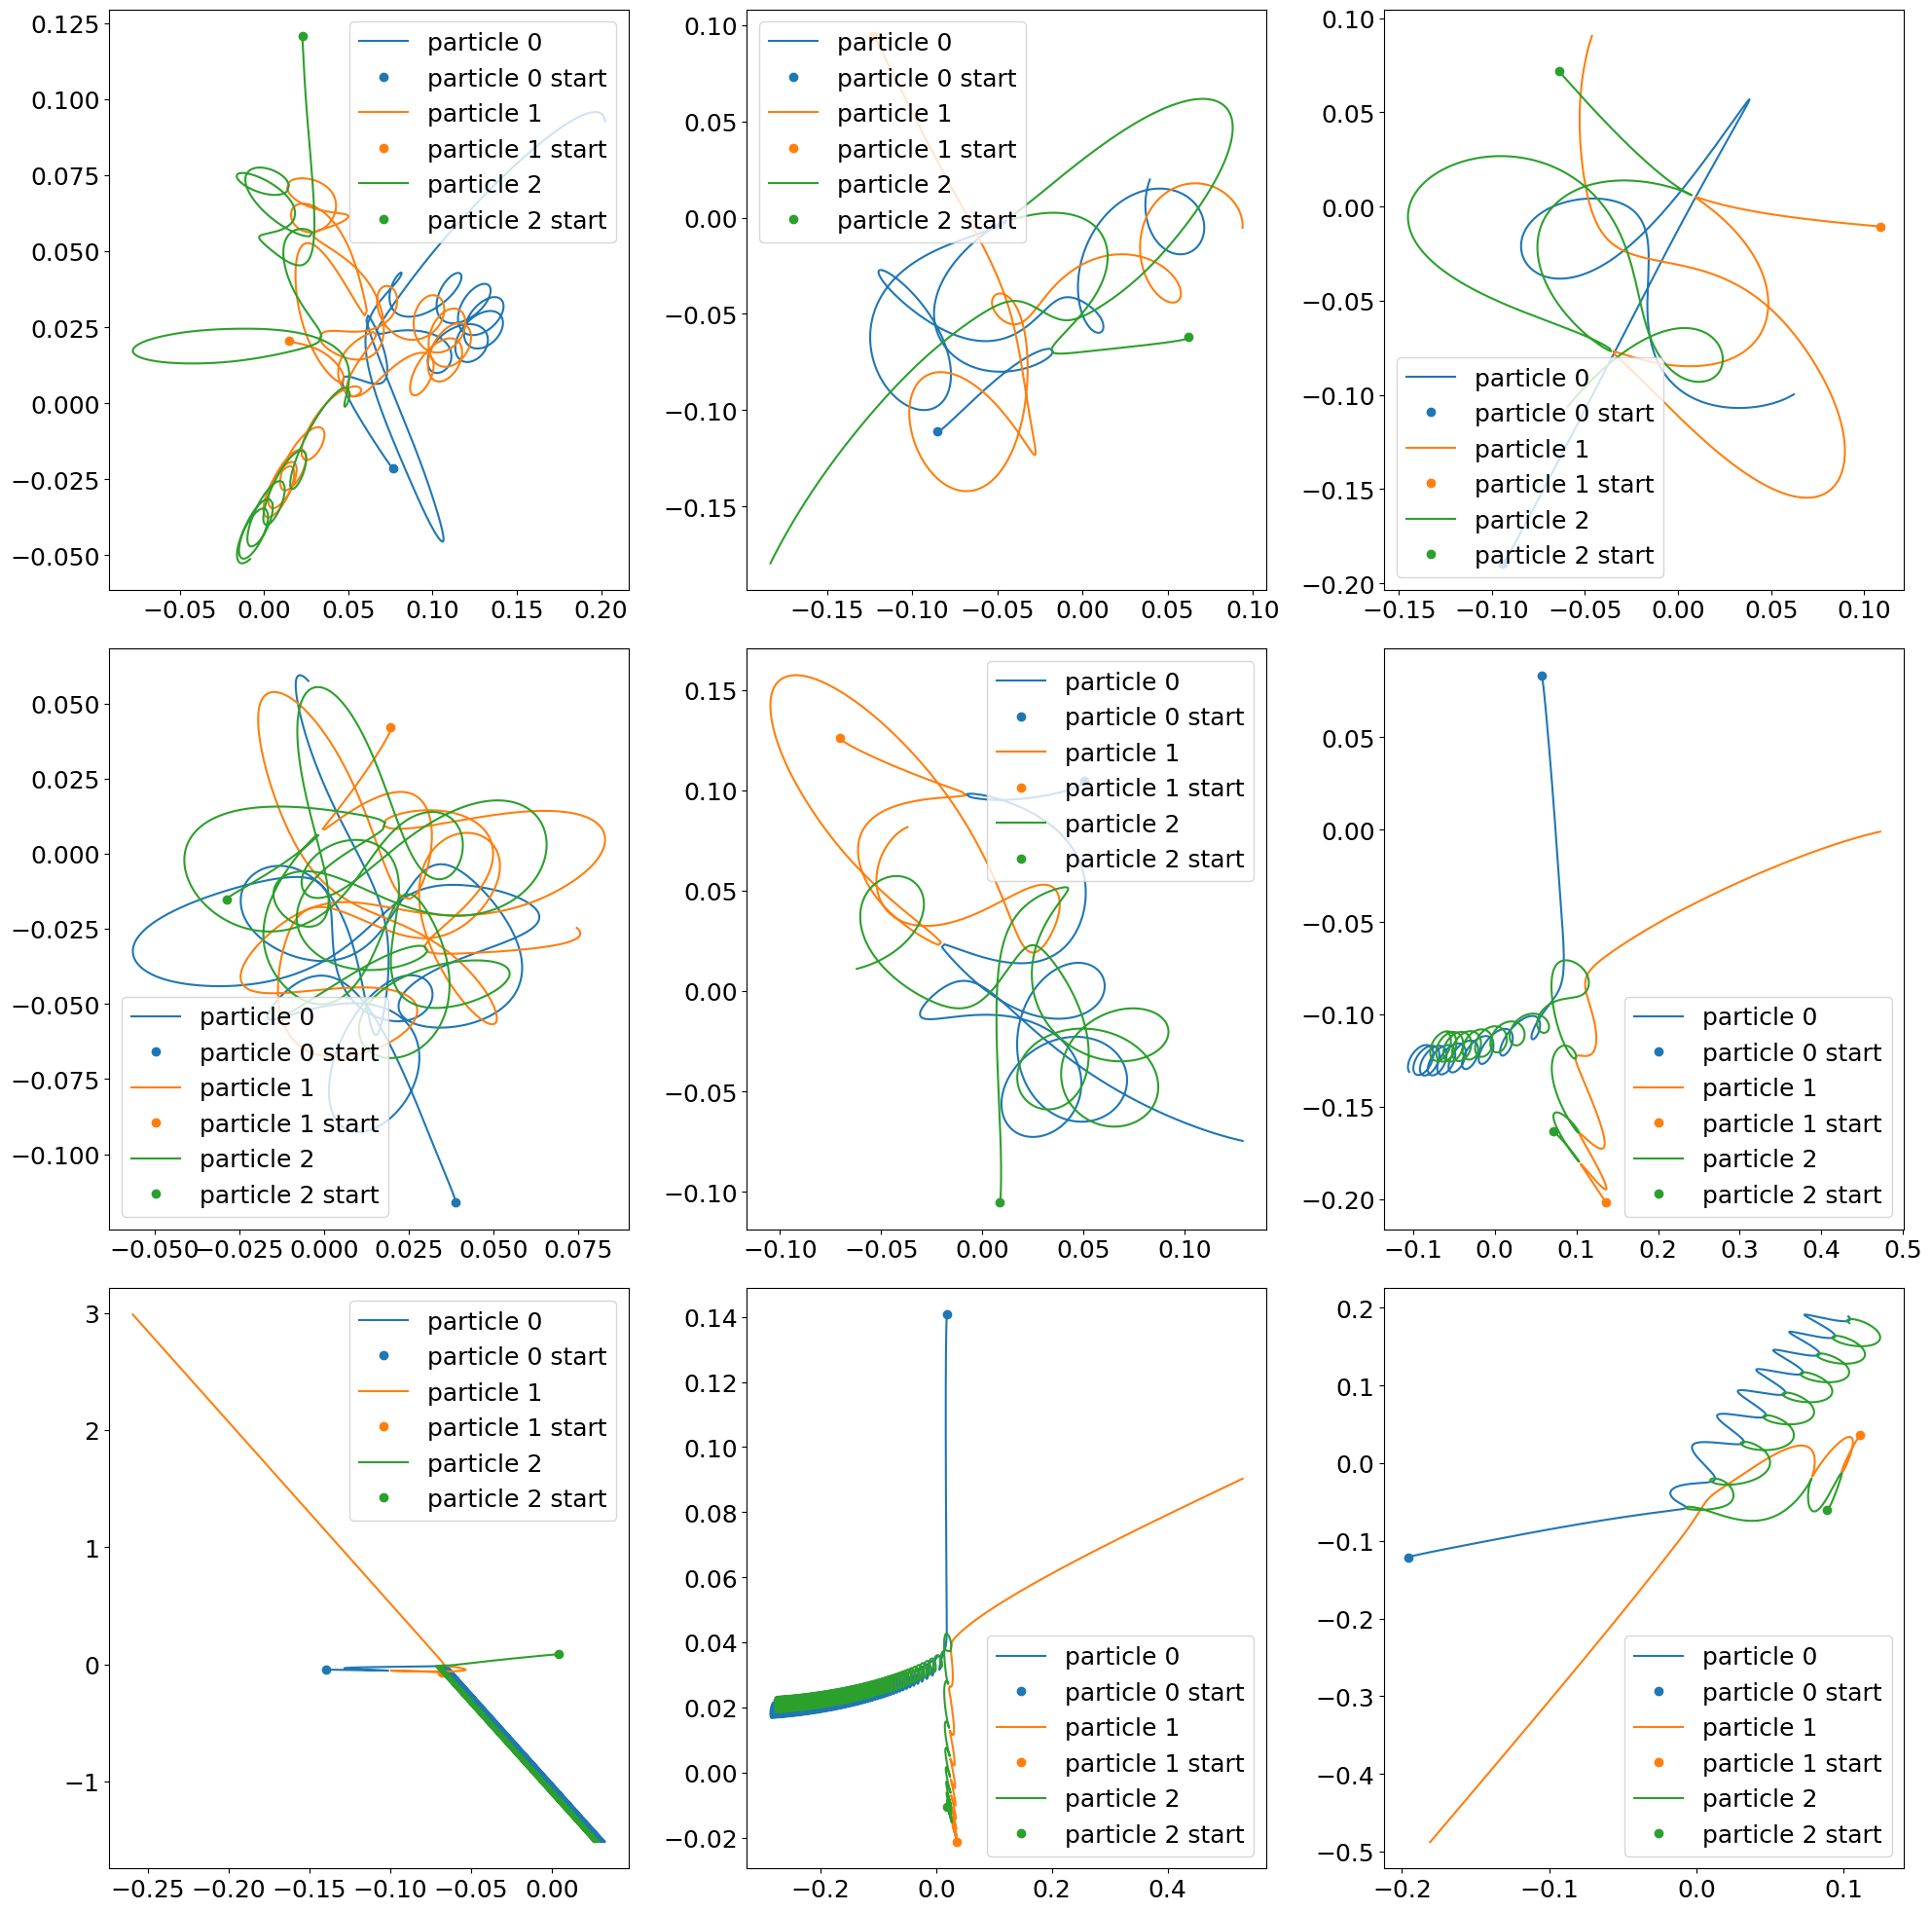

In [87]:
plot_multiple(sims)

(3001, 12)
(3001, 12)
(3001, 12)


array([[ 0.01607416, -0.10885096, -0.10524541, ...,  0.0911986 ,
         0.17439946, -0.06879344],
       [ 0.01606322, -0.11008369, -0.10526077, ...,  0.08918223,
         0.17439167, -0.08683817],
       [ 0.01605215, -0.11131619, -0.10527588, ...,  0.08716485,
         0.17438209, -0.10488439],
       ...,
       [-0.73487283, -2.8389903 ,  0.67693284, ...,  1.16356947,
        -0.30129976,  8.2200934 ],
       [-0.73515673, -2.83894786,  0.67719939, ...,  0.53807061,
        -0.30038845, 10.19172719],
       [-0.73544062, -2.83890547,  0.67746595, ..., -1.48880592,
        -0.29918907, 14.55567219]])

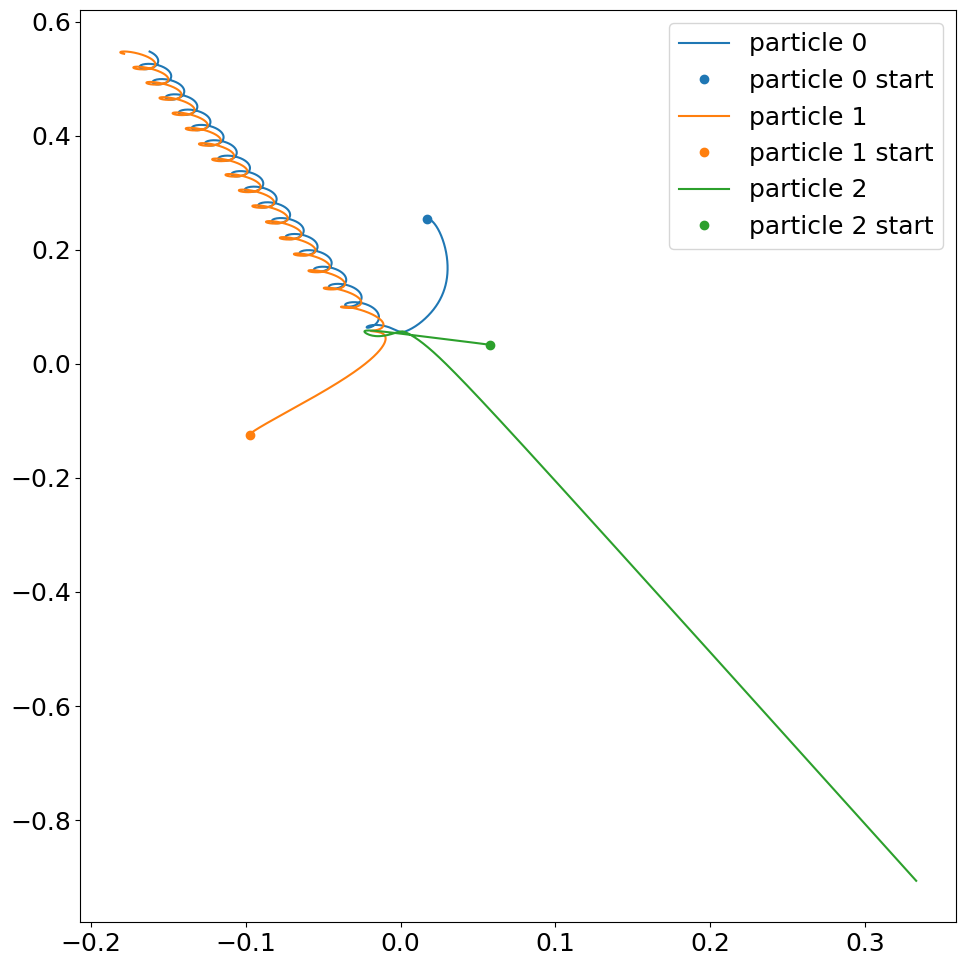

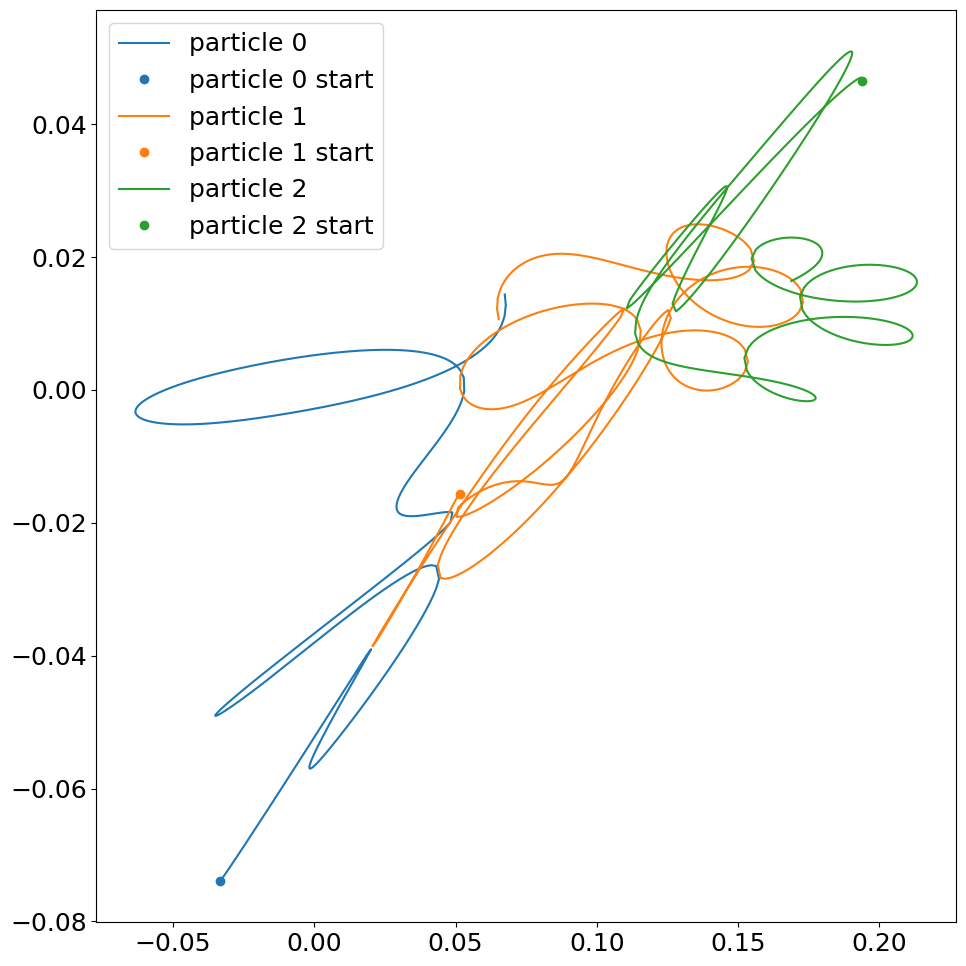

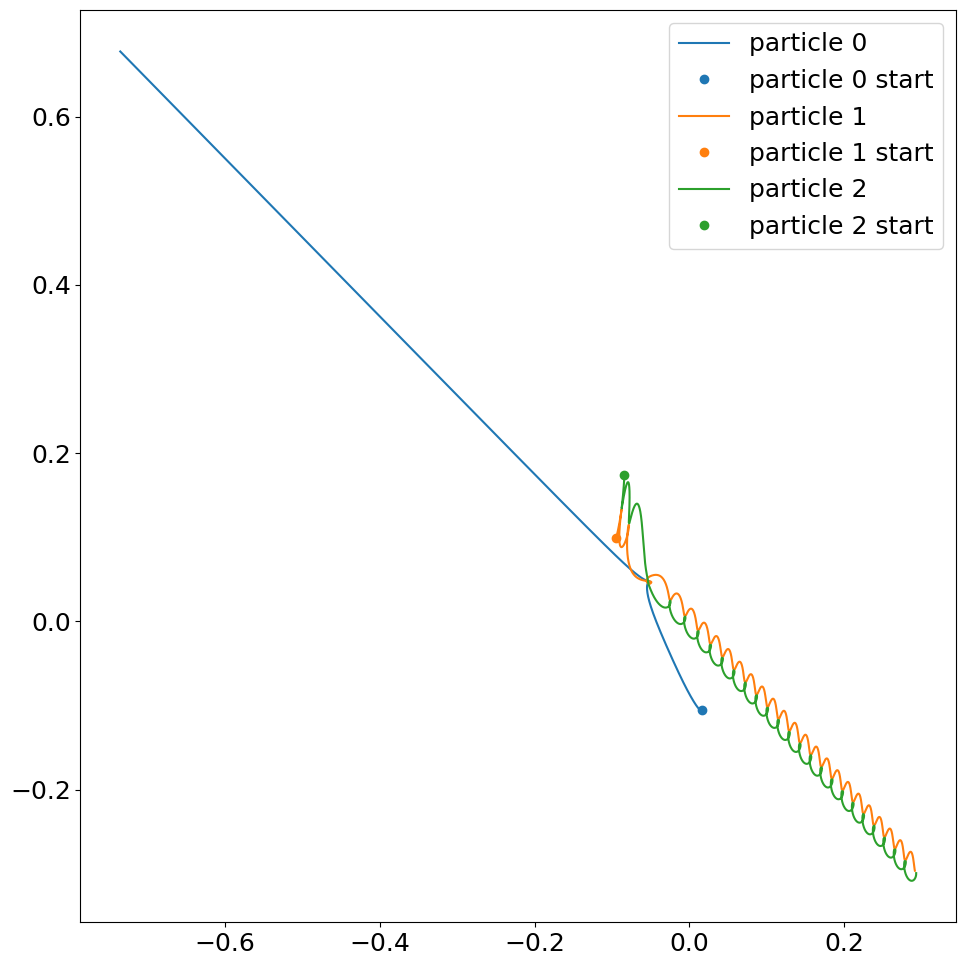

In [69]:
sim = Yukawa3body()
np.random.seed(102938)
for i in range(3):
    sim.generate_init_cond()
    sim.simulate(3e-1,dt=1e-4)
    print(sim.x.shape)
    sim.plot(which='position')

sim.x


# Hard-coded 3-body simulation

In [30]:
def Yukawa_3body_EOM(t, x, potential:str='attractive'):
    # str var potential can be 'attractive' or 'repulsive'.
    if potential == 'attractive':
        a = -1
    elif potential == 'repulsive':
        a = 1
    else:
        raise ValueError("str var potential must be either 'attractive' or 'repulsive'")
    
    return [## PARTICLE 1
            # x
            x[1],
            a*(x[ 0] - x[ 4]) * np.exp( -np.sqrt( (x[ 0] - x[ 4])**2 + (x[ 2] - x[ 6])**2 ) ) * ( ( (x[ 0] - x[ 4])**2 + (x[ 2] - x[ 6])**2 )**(-1) + ( (x[ 0] - x[ 4])**2 + (x[ 2] - x[ 6])**2 )**(-3/2) ) + # 12 interaction
            a*(x[ 0] - x[ 8]) * np.exp( -np.sqrt( (x[ 0] - x[ 8])**2 + (x[ 2] - x[10])**2 ) ) * ( ( (x[ 0] - x[ 8])**2 + (x[ 2] - x[10])**2 )**(-1) + ( (x[ 0] - x[ 8])**2 + (x[ 2] - x[10])**2 )**(-3/2) ), # 13 interaction
            # y
            x[3],
            a*(x[ 2] - x[ 6]) * np.exp( -np.sqrt( (x[ 0] - x[ 4])**2 + (x[ 2] - x[ 6])**2 ) ) * ( ( (x[ 0] - x[ 4])**2 + (x[ 2] - x[ 6])**2 )**(-1) + ( (x[ 0] - x[ 4])**2 + (x[ 2] - x[ 6])**2 )**(-3/2) ) + # 12 interaction
            a*(x[ 2] - x[10]) * np.exp( -np.sqrt( (x[ 0] - x[ 8])**2 + (x[ 2] - x[10])**2 ) ) * ( ( (x[ 0] - x[ 8])**2 + (x[ 2] - x[10])**2 )**(-1) + ( (x[ 0] - x[ 8])**2 + (x[ 2] - x[10])**2 )**(-3/2) ) , # 13 interaction
            ## PARTICLE 2
            # x
            x[5],
            a*(x[ 4] - x[ 8]) * np.exp( -np.sqrt( (x[ 4] - x[ 8])**2 + (x[ 6] - x[10])**2 ) ) * ( ( (x[ 4] - x[ 8])**2 + (x[ 6] - x[10])**2 )**(-1) + ( (x[ 4] - x[ 8])**2 + (x[ 6] - x[10])**2 )**(-3/2) ) + # 23 interaction
            a*(x[ 4] - x[ 0]) * np.exp( -np.sqrt( (x[ 4] - x[ 0])**2 + (x[ 6] - x[ 2])**2 ) ) * ( ( (x[ 4] - x[ 0])**2 + (x[ 6] - x[ 2])**2 )**(-1) + ( (x[ 4] - x[ 0])**2 + (x[ 6] - x[ 2])**2 )**(-3/2) ) , # 21 interaction
            # y
            x[7],
            a*(x[ 6] - x[10]) * np.exp( -np.sqrt( (x[ 4] - x[ 8])**2 + (x[ 6] - x[10])**2 ) ) * ( ( (x[ 4] - x[ 8])**2 + (x[ 6] - x[10])**2 )**(-1) + ( (x[ 4] - x[ 8])**2 + (x[ 6] - x[10])**2 )**(-3/2) ) + # 23 interaction
            a*(x[ 6] - x[ 2]) * np.exp( -np.sqrt( (x[ 4] - x[ 0])**2 + (x[ 6] - x[ 2])**2 ) ) * ( ( (x[ 4] - x[ 0])**2 + (x[ 6] - x[ 2])**2 )**(-1) + ( (x[ 4] - x[ 0])**2 + (x[ 6] - x[ 2])**2 )**(-3/2) ) , # 21 interaction
            ## PARTICLE 3
            # x
            x[9],
            a*(x[ 8] - x[ 0]) * np.exp( -np.sqrt( (x[ 8] - x[ 0])**2 + (x[10] - x[ 2])**2 ) ) * ( ( (x[ 8] - x[ 0])**2 + (x[10] - x[ 2])**2 )**(-1) + ( (x[ 8] - x[ 0])**2 + (x[10] - x[ 2])**2 )**(-3/2) ) + # 31 interaction
            a*(x[ 8] - x[ 4]) * np.exp( -np.sqrt( (x[ 8] - x[ 4])**2 + (x[10] - x[ 6])**2 ) ) * ( ( (x[ 8] - x[ 4])**2 + (x[10] - x[ 6])**2 )**(-1) + ( (x[ 8] - x[ 4])**2 + (x[10] - x[ 6])**2 )**(-3/2) ) , # 32 interaction
            # y
            x[11],
            a*(x[10] - x[ 2]) * np.exp( -np.sqrt( (x[ 8] - x[ 0])**2 + (x[10] - x[ 2])**2 ) ) * ( ( (x[ 8] - x[ 0])**2 + (x[10] - x[ 2])**2 )**(-1) + ( (x[ 8] - x[ 0])**2 + (x[10] - x[ 2])**2 )**(-3/2) ) + # 31 interaction
            a*(x[10] - x[ 6]) * np.exp( -np.sqrt( (x[ 8] - x[ 4])**2 + (x[10] - x[ 6])**2 ) ) * ( ( (x[ 8] - x[ 4])**2 + (x[10] - x[ 6])**2 )**(-1) + ( (x[ 8] - x[ 4])**2 + (x[10] - x[ 6])**2 )**(-3/2) )   # 32 interaction
            ]

In [97]:
def simulate(duration, dt=1e-3, 
             init_cond=[0, 1e-2, 0, 1e-2,   1, -1e-2, 0, 1e-2,   0, 1e-2, 1, -1e-2]
             ):
    # create time grid
    t = np.arange(0,duration+dt,dt)
    t_span = (t[0], t[-1])

    # solve initial value problem and return trajectories
    x = solve_ivp(Yukawa_3body_EOM, t_span, init_cond, t_eval=t, **integrator_keywords).y.T
    return x

In [98]:
# init_cond = [0, -2e-1, 0, -2e-1,   1e-1, -1e-1, 0, 0,   0, 0, 1e-1, 0]
# randomize initial conditions
np.random.seed(346734)
init_cond = np.random.normal(0.0, 1e-1, (12,))
print(init_cond)

[ 0.07657867  0.06865165 -0.02142783 -0.14568978  0.01463115  0.20249003
  0.02044765 -0.07601812  0.02267935  0.03319853  0.12088104 -0.1139447 ]


In [99]:
x = simulate(4e-2, dt=1e-5, init_cond=init_cond)

In [100]:
def plot(x:np.ndarray, which:str='position', init_cond=[0, 1e-2, 0, 1e-2,   1, -1e-2, 0, 1e-2,   0, 1e-2, 1, -1e-2]):
    if which == 'position':
        loop_start = 0
    elif which == 'velocity':
        loop_start = 1
    else:
        raise ValueError("str var which must be either 'position' or 'velocity'")
    # visualize trajectories
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    colors = ['C0','C1','C2']

    # plot x- and y-axes
    # ax.axhline(0, color='black', linewidth=.5)
    # ax.axvline(0, color='black', linewidth=.5)

    # plot trajectories
    for i in range( loop_start, x.shape[1], 4 ):
        label = f"particle {i//4}"
        # plot particle trajectories
        ax.plot(x[:,i], x[:,i+2], colors[i//4], label=label)
        # plot dots for ptcl init position
        ax.plot(init_cond[i],init_cond[i+2], colors[i//4] + 'o', label=label + " start")
        # add if statement: if init vel == 0 do not execute
        # add arrows to show initial velocities
        # ax.arrow(init_cond[i],
        #          init_cond[i+2],
        #          init_cond[i+1]//1e6,
        #          init_cond[i+3]//1e6
        #          )
    ax.legend()

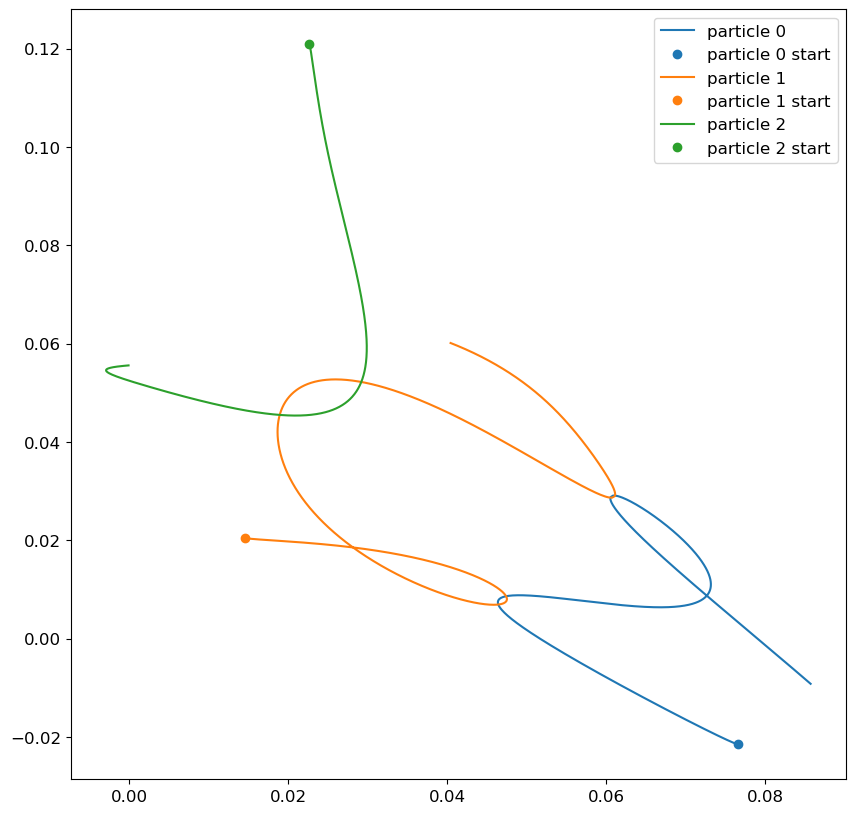

In [101]:
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'figure.figsize': (2,2)})
plot(x,init_cond=init_cond)

# Optimized n-body code

Can this code be optimized to be a loop? Let's check the type of the output of the callable EOMs.

In [102]:
x = Yukawa_3body_EOM(0, [0, 0.1, 0, 0,   0.1, 0, 0, 0,   0, 0, 0.1, 0])
print(type(x))
print(x)

<class 'list'>
[0.1, 99.53211598395552, 0, 99.53211598395552, 0, -134.56553196820545, 0, 35.03341598424994, 0, 35.03341598424994, 0, -134.56553196820545]


We can definitely try to make a list inside of a for-loop to see if it will work with `solve_ivp`.

In [112]:
np.arange(0,8)//4

array([0, 0, 0, 0, 1, 1, 1, 1], dtype=int32)

In [ ]:
def Yukawa_nbody_EOM_opt(t, x): 
    n_bodies: int = 3
    n_dim: int = 2
    n_eqs = 2 * n_bodies * n_dim

    if n_dim > 3:
        raise ValueError("n_dim must be <= 3")

    x = np.empty(n_eqs)
    distances = np.empty(n_dim)
    EOMs = []

    for i in range(n_eqs):
    # this for-loop goes through all the equations, i is the index of list EOMs
    # i // 4 is the particle index.
        print("i = ", i)
        # for even indices, put in velocities
        if i % 2 == 0:
            EOMs.append(x[i+1])
            continue
        
        EOM_i = 0
        for j in range(n_bodies-1):
        # this for-loop goes through the interaction terms between all particles.
            print("j = ", j)
            # check if j = i
            if j == i:
                continue
            for k in range(n_dim):
            # this for-loop goes through all the dimensions. for each dimension, it adds the
            # necessary term to the euclidean distance between particles i and j.
                print("k = ", k)
                distances[k] = x[i-1] - x[(i+3) * (j+1) + 2*j]

                term = x[i-1] - x[(i+3) * (j+1) + 2*k]
                distance_ij += term

            # check
            # i=3
            # j=1
            term = -(x[i-1] - x[(i+3) * (j+1) + 2*j]) * np.exp( -np.sqrt( (x[i-1] - x[(i+3) * (j+1)])**2 + (x[i+1] - x[(i+3) * (j+1) + 2])**2 ) ) * ( ( (x[i-1] - x[(i+3) * (j+1)])**2 + (x[i+1] - x[(i+3) * (j+1) + 2])**2 )**(-1) + ( (x[i-1] - x[(i+3) * (j+1)])**2 + (x[i+1] - x[(i+3) * (j+1) + 2])**2 )**(-3/2) )
                #  -(x[ 2] - x[10]) * np.exp( -np.sqrt( (x[ 0] - x[ 8])**2 + (x[ 2] - x[10])**2 ) ) * ( ( (x[ 0] - x[ 8])**2 + (x[ 2] - x[10])**2 )**(-1) + ( (x[ 0] - x[ 8])**2 + (x[ 2] - x[10])**2 )**(-3/2) ) , # 13 interaction
            
            
            EOM_i += term
        
        # Append ith EOM to EOMs list
        EOMs.append(EOM_i)
    
    return EOMs

In [110]:
y = Yukawa_nbody_EOM_opt(0, [0, 0.1, 0, 0,   0.1, 0, 0, 0,   0, 0, 0.1, 0])
print(y)

i =  0
i =  1
j =  0
j =  1
i =  2
i =  3
j =  0
j =  1


C:\Users\zacha\AppData\Local\Temp\ipykernel_49796\3016007907.py:27: RuntimeWarning: divide by zero encountered in scalar power
  ( ( (x[i-1] - x[(i+3) * (j+1)])**2 + (x[i+1] - x[(i+3) * (j+1) + 2])**2 )**(-1) +
C:\Users\zacha\AppData\Local\Temp\ipykernel_49796\3016007907.py:28: RuntimeWarning: divide by zero encountered in scalar power
  ( (x[i-1] - x[(i+3) * (j+1)])**2 + (x[i+1] - x[(i+3) * (j+1) + 2])**2 )**(-3/2)
C:\Users\zacha\AppData\Local\Temp\ipykernel_49796\3016007907.py:23: RuntimeWarning: invalid value encountered in scalar multiply
  term = -(x[i-1] - x[(i+3) * (j+1)]) * \


IndexError: index 12 is out of bounds for axis 0 with size 12

# SINDy Stuff

## Overly large library

This is an example of how difficult and complicated the library can get. If we leave the feature space as it is, we have to iterate over four variables, which creates a massive library with $\begin{pmatrix}12\\4\end{pmatrix}=495$ terms just from the single library term shown below.

In [45]:
library_functions = [
    lambda w, x, y, z: (w - x) * np.exp(-np.sqrt((x - w)**2 + (y - z)**2)) / ( (x - w)**2 + (y - z)**2 ),
]
custom_library = ps.CustomLibrary(
    library_functions=library_functions,
)

In [46]:
feature_names = [
    "x0",
    "vx0"
    "y0",
    "vy0",

    "x1",
    "vx1",
    "y1",
    "vy1",
    
    "x2",
    "vx2",
    "y2",
    "vy2",
]

Testing this out with a random $100 \times 12$ data matrix we can easily test that the library is indeed that large.

In [47]:
x_rand = random.rand(100, 12)
t_rand = np.arange(100)

# model = ps.SINDy(feature_names=feature_names,feature_library=custom_library)
model = ps.SINDy(feature_library=custom_library)
# model = ps.SINDy()
model.fit(x_rand, t=t_rand)
long_list = model.get_feature_names()
# model.coefficients()
# model.print()

c:\Users\zacha\anaconda3\envs\yukawa-project\Lib\site-packages\pysindy\optimizers\stlsq.py:191: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(


In [109]:
def check_library_length(lib):
    # Random data to check lib
    x = random.rand(100, 12)
    t = np.arange(100)

    opt = ps.STLSQ(threshold=0)
    model = ps.SINDy(optimizer=opt,feature_library=lib)
    model.fit(x, t=t)
    long_list = model.get_feature_names()

    return print("Length of library:", len(long_list),"terms")

In [49]:
check_library_length(custom_library)

Length of library: 495 terms


## Change of coordinates

One way to reduce the size of the library is to transform the feature space in the following way:

$\begin{bmatrix}
    x_0     \\
    v_{x0}  \\
    y_0     \\
    v_{y0}  \\
    x_1     \\
    v_{x1}  \\
    y_1     \\
    v_{y1}  \\
    x_2     \\
    v_{x2}  \\
    y_2     \\
    v_{y2}  \\
\end{bmatrix}
\to
\begin{bmatrix}
    x_0 - x_1       \\
    v_{x0} - v_{x1} \\
    y_0 - y_1       \\
    v_{y0} - v_{y1} \\
    x_1 - x_2       \\
    v_{x1} - v_{x2} \\
    y_1 - y_2       \\
    v_{y1} - v_{y2} \\
    x_2 - x_0       \\
    v_{x2} - v_{x0} \\
    y_2 - y_0       \\
    v_{y2} - v_{y0} \\
\end{bmatrix}$

This is a convenient transformation in part because of the fact that we can write $\frac{d}{dt}\left(x_i-x_j\right)=\left(\dot{x_i}-\dot{x_j}\right)=\left(v_{xi}-v_{xj}\right)$, which means that there is not much of a change to the governing equations of the system.

This reduces the size of the library because the basis functions can be written with only two variables instead of four.

### Testing with random data

We begin by testing to see if the library of functions is indeed smaller. Using just one of the basis functions, now re-defined with just two variables, we can see if the length is indeed $\begin{pmatrix}12\\2\end{pmatrix}=66$ terms using random data.

In [146]:
library_functions = [
    lambda x, y: x * np.exp( np.sqrt( x**2 + y**2 ) ) / ( x**2 + y**2 )
]
custom_library = ps.CustomLibrary(
    library_functions=library_functions,
)

In [147]:
x = random.rand(100, 12)
t = np.arange(100)

# model = ps.SINDy(feature_names=feature_names,feature_library=custom_library)
model = ps.SINDy(feature_library=custom_library)
# model = ps.SINDy()
model.fit(x, t=t)
long_list = model.get_feature_names()

c:\Users\zacha\anaconda3\envs\yukawa-project\Lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
c:\Users\zacha\anaconda3\envs\yukawa-project\Lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
c:\Users\zacha\anaconda3\envs\yukawa-project\Lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
c:\Users\zacha\anaconda3\envs\yukawa-project\Lib\site-packages\pysindy\optimizers\stlsq.py:191: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(


In [148]:
len(long_list)

66

As we can see, given this basis function, SINDy generates 66 terms. Now, we still have a problem in that any of the terms that include a velocity function are extraneous, but it is a good first step to see if SINDy can ignore these terms. We now proceed with the change of coordinates using the real data, contained in the variable `x`.

### Performing change of coordinates

In [203]:
def subtract_data(x_simulated):
    # create array of labels
    x_labels = np.array([(f"x{i}", f"vx{i}", f"y{i}", f"vy{i}") for i in range(3)]).reshape((12,))
    # generate repeated list of indices
    idxs = np.tile(np.arange(0,12),2)
    # transform labels and data to be subtracted as explained above
    x_subtracted_labels = np.hstack([x_labels[i] + "-" + x_labels[j] for i,j in zip(idxs[:12],idxs[4:])])
    x_subtracted = np.vstack([x_simulated[:,i]-x_simulated[:,j] for i,j in zip(idxs[:12],idxs[4:])]).T
    return x_subtracted, x_subtracted_labels

In [200]:
np.array([(f"x{i}", f"vx{i}", f"y{i}", f"vy{i}") for i in range(3)]).reshape((12,))

array(['x0', 'vx0', 'y0', 'vy0', 'x1', 'vx1', 'y1', 'vy1', 'x2', 'vx2',
       'y2', 'vy2'], dtype='<U3')

In [ ]:
# old code:
# create array of labels for intelligibility
labels = np.array([(f"x{i}", f"vx{i}", f"y{i}", f"vy{i}") for i in range(3)]).reshape((12,))
# iterate over indices to generate a list of new labels and transformed data
# idxs = np.concatenate((np.arange(0,12),np.arange(0,4)))
idxs = np.tile(np.arange(0,12),2)

# labels
x_train_labels = np.hstack([labels[i] + "-" + labels[j] for i,j in zip(idxs[:12],idxs[4:])])
print(x_train_labels)

# data
x_train = np.vstack([x[:,i]-x[:,j] for i,j in zip(idxs[:12],idxs[4:])]).T
print('shape:', x_train.shape)

['x0-x1' 'vx0-vx1' 'y0-y1' 'vy0-vy1' 'x1-x2' 'vx1-vx2' 'y1-y2' 'vy1-vy2'
 'x2-x0' 'vx2-vx0' 'y2-y0' 'vy2-vy0']
shape: (4001, 12)


In [103]:
labels

array(['x0', 'vx0', 'y0', 'vy0', 'x1', 'vx1', 'y1', 'vy1', 'x2', 'vx2',
       'y2', 'vy2'], dtype='<U3')

**SIDE NOTE**: just doing a quick check to get a sense for the magnitude of the data, we can see that the magnitudes of the position data varies much less, generally between -0.1 and +0.1, whereas the velocity data varies much more, between =100 and +100.

In [ ]:
x_min = np.min(x_train,axis=0)
x_max = np.max(x_train,axis=0)
print(np.array([x_train_labels[i] + " min: " + str(x_min[i]) + ", max: " + str(x_max[i]) for i in range(len(x_labels))]))

['x0-x1 min: -0.001136570794736752, max: 0.061947518786521896'
 'vx0-vx1 min: -92.96955936717968, max: 47.40595135559338'
 'y0-y1 min: -0.06932239707042823, max: 0.001898727493515216'
 'vy0-vy1 min: -80.33444552487855, max: 58.66521097389837'
 'x1-x2 min: -0.011216816330797793, max: 0.059180377116784234'
 'vx1-vx2 min: -24.098193295765494, max: 49.72149005511947'
 'y1-y2 min: -0.10043338675145366, max: 0.007237463595630732'
 'vy1-vy2 min: -25.33348796885063, max: 38.52879618139686'
 'x2-x0 min: -0.08575302576375385, max: -0.021395333683830318'
 'vx2-vx0 min: -23.307758059827886, max: 43.24806931206022'
 'y2-y0 min: 0.022393511797754225, max: 0.14231068120755752'
 'vy2-vy0 min: -33.33172300504774, max: 41.80564934348169']


[[ 0.07657867  0.06865165 -0.02142783 -0.14568978  0.01463115  0.20249003
   0.02044765 -0.07601812  0.02267935  0.03319853  0.12088104 -0.1139447 ]
 [ 0.06194752 -0.13383838 -0.04187548 -0.06967166 -0.0080482   0.16929149
  -0.10043339  0.03792658 -0.05389932 -0.03545312  0.14230887  0.03174508]]


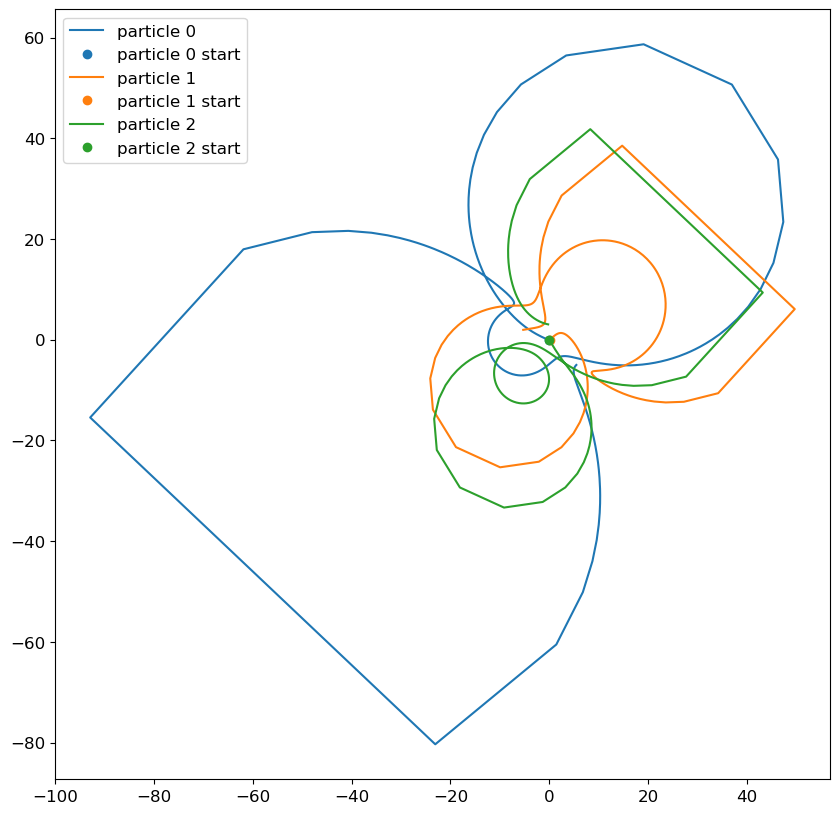

In [ ]:
# plot the data in the new space
init_cond_new = [init_cond[i]-init_cond[j] for i,j in zip(idxs[:12],idxs[4:])]
# print("old:",init_cond)
# print("new:",init_cond_new)
print(np.vstack((np.array(init_cond),np.array(init_cond_new))))
plot(x,which='velocity',init_cond=init_cond_new)

## Second try at SINDy library

In [22]:
# define custom library of terms only with the terms we are in need of. Will create a library
# of 66+66+12=144 terms.
library_functions = [
    lambda x: x,
    lambda x, y: x * np.exp( np.sqrt( x**2 + y**2 ) ) / ( x**2 + y**2 ),
    lambda x, y: x * np.exp( np.sqrt( x**2 + y**2 ) ) / ( x**2 + y**2 )**(3/2)
]
library_function_names = [
    lambda x: x,
    lambda x,y: x + " exp( sqrt( " + x + "^2 + " + y + "^2 ) ) / ( " + x + "^2 + " + y + "^2 )",
    lambda x,y: x + " exp( sqrt( " + x + "^2 + " + y + "^2 ) ) / ( " + x + "^2 + " + y + "^2 )^(3/2)"
]
custom_library = ps.CustomLibrary(
    library_functions=library_functions, 
    function_names=library_function_names
)

The above creates a library with too many terms. We want the first (linear) term to only be a function of velocity, and the latter 2 "Yukawa" library terms to only be functions of position, not velocity. This can be done by creating two separate custom libraries and then combining them via the generalized library.

In [ ]:
# define custom library of terms with only yukawa (rational) terms
library_functions = [
    lambda x, y: x * np.exp( np.sqrt( x**2 + y**2 ) ) / ( x**2 + y**2 ),
    lambda x, y: x * np.exp( np.sqrt( x**2 + y**2 ) ) / ( x**2 + y**2 )**(3/2)
]
library_function_names = [
    lambda x,y: x + " exp( sqrt( " + x + "^2 + " + y + "^2 ) ) / ( " + x + "^2 + " + y + "^2 )",
    lambda x,y: x + " exp( sqrt( " + x + "^2 + " + y + "^2 ) ) / ( " + x + "^2 + " + y + "^2 )^(3/2)"
]
yukawa_library_test = ps.CustomLibrary(
    library_functions=library_functions, 
    function_names=library_function_names
)

# create identity library for the definition terms x' = v, etc.
identity_library = ps.IdentityLibrary()

In [60]:
x_train.shape

(4001, 12)

In [61]:
lib=identity_library.fit(x_train).transform(x_train)
lib.shape

(4001, 12)

In [ ]:
# input only velocities to first library and only positions to second library
num_features:int = x_train.shape[1]
pos_idxs = [i for i in range(0,num_features,2)]
vel_idxs = [i+1 for i in range(0,num_features,2)]
inputs_per_library = np.array([vel_idxs,pos_idxs])
generalized_library_test = ps.GeneralizedLibrary(
    [identity_library, yukawa_library_test],
    inputs_per_library=inputs_per_library
)


In [ ]:
check_library_length(generalized_library_test)

Length of library: 36 terms


Note: The file '1_feature_overview.ipynb' saved locally allows the variable `inputs_per_library` to be a sequence of sequences of integers. However, the code only runs when `inputs_per_library` is a `np.NdArray` object. It appears this was changed in a later version than what is currently being used.

The version downloaded in the current anaconda venv, 'yukawa-project', is 1.7.5. GitHub lists this version as the latest version, but the code written in the aforementioned example notebook does not run with this version. Looking back at the same file under the v1.7.5 tag on GitHub helped me to write code that would work.

Let's check with our test data to see how SINDy fits using the library we have defined above.

In [ ]:
opt = ps.STLSQ(threshold=0.002)
model = ps.SINDy(optimizer=opt, feature_names=x_train_labels, feature_library=generalized_library_test)
model.fit(x_train, t=1e-3)
model.print()

(x0-x1)' = 0.010 vx0-vx1
(vx0-vx1)' = 31612162745.718 vx0-vx1 + -91.623 vy0-vy1 + 31612162347.398 vx1-vx2 + 262.870 vy1-vy2 + 31612163501.010 vx2-vx0 + -171.249 vy2-vy0 + -26.398 x0-x1 exp( sqrt( x0-x1^2 + y0-y1^2 ) ) / ( x0-x1^2 + y0-y1^2 ) + 937.626 x0-x1 exp( sqrt( x0-x1^2 + x1-x2^2 ) ) / ( x0-x1^2 + x1-x2^2 ) + 189.015 x0-x1 exp( sqrt( x0-x1^2 + y1-y2^2 ) ) / ( x0-x1^2 + y1-y2^2 ) + -2946.936 x0-x1 exp( sqrt( x0-x1^2 + x2-x0^2 ) ) / ( x0-x1^2 + x2-x0^2 ) + -129.614 x0-x1 exp( sqrt( x0-x1^2 + y2-y0^2 ) ) / ( x0-x1^2 + y2-y0^2 ) + 32.140 y0-y1 exp( sqrt( y0-y1^2 + x1-x2^2 ) ) / ( y0-y1^2 + x1-x2^2 ) + -523.993 y0-y1 exp( sqrt( y0-y1^2 + y1-y2^2 ) ) / ( y0-y1^2 + y1-y2^2 ) + -2342.211 y0-y1 exp( sqrt( y0-y1^2 + x2-x0^2 ) ) / ( y0-y1^2 + x2-x0^2 ) + 5958.419 y0-y1 exp( sqrt( y0-y1^2 + y2-y0^2 ) ) / ( y0-y1^2 + y2-y0^2 ) + 83.153 x1-x2 exp( sqrt( x1-x2^2 + y1-y2^2 ) ) / ( x1-x2^2 + y1-y2^2 ) + -3601.786 x1-x2 exp( sqrt( x1-x2^2 + x2-x0^2 ) ) / ( x1-x2^2 + x2-x0^2 ) + 4788.332 x1-x2 exp(

In [ ]:
model.get_feature_names()

['vx0-vx1',
 'vy0-vy1',
 'vx1-vx2',
 'vy1-vy2',
 'vx2-vx0',
 'vy2-vy0',
 'x0-x1 exp( sqrt( x0-x1^2 + y0-y1^2 ) ) / ( x0-x1^2 + y0-y1^2 )',
 'x0-x1 exp( sqrt( x0-x1^2 + x1-x2^2 ) ) / ( x0-x1^2 + x1-x2^2 )',
 'x0-x1 exp( sqrt( x0-x1^2 + y1-y2^2 ) ) / ( x0-x1^2 + y1-y2^2 )',
 'x0-x1 exp( sqrt( x0-x1^2 + x2-x0^2 ) ) / ( x0-x1^2 + x2-x0^2 )',
 'x0-x1 exp( sqrt( x0-x1^2 + y2-y0^2 ) ) / ( x0-x1^2 + y2-y0^2 )',
 'y0-y1 exp( sqrt( y0-y1^2 + x1-x2^2 ) ) / ( y0-y1^2 + x1-x2^2 )',
 'y0-y1 exp( sqrt( y0-y1^2 + y1-y2^2 ) ) / ( y0-y1^2 + y1-y2^2 )',
 'y0-y1 exp( sqrt( y0-y1^2 + x2-x0^2 ) ) / ( y0-y1^2 + x2-x0^2 )',
 'y0-y1 exp( sqrt( y0-y1^2 + y2-y0^2 ) ) / ( y0-y1^2 + y2-y0^2 )',
 'x1-x2 exp( sqrt( x1-x2^2 + y1-y2^2 ) ) / ( x1-x2^2 + y1-y2^2 )',
 'x1-x2 exp( sqrt( x1-x2^2 + x2-x0^2 ) ) / ( x1-x2^2 + x2-x0^2 )',
 'x1-x2 exp( sqrt( x1-x2^2 + y2-y0^2 ) ) / ( x1-x2^2 + y2-y0^2 )',
 'y1-y2 exp( sqrt( y1-y2^2 + x2-x0^2 ) ) / ( y1-y2^2 + x2-x0^2 )',
 'y1-y2 exp( sqrt( y1-y2^2 + y2-y0^2 ) ) / ( y1-y2^2 + y2

Most of the terms in this library are still junk, since the only arguments we want for each of the terms are ones which match each other, i.e. in the argument of the exponential we want

$\sqrt{(x_i-x_j)^2+(y_i-y_j)^2}$

with the particle indices $i,j\in\{0,1,2\}$ such that $i\neq j$. To do this, we will need a bit more code as we will need to create an individual library for each of the particle combinations $i,j$, and then combine them using the generalized library.

Another issue with this library is that by default SINDy does *combinations* of all of the library function inputs, not *permutations*. This is because of the way the `yukawa_library` library object is defined. To fix this we need to add more terms in the definition of `yukawa_library`. We begin by addressing this issue first.

## Correct Library

In [106]:
# define custom library of terms with only yukawa (rational) terms
library_functions = [
    lambda x, y: x * np.exp( np.sqrt( x**2 + y**2 ) ) / ( x**2 + y**2 ),
    lambda x, y: y * np.exp( np.sqrt( x**2 + y**2 ) ) / ( x**2 + y**2 ),
    lambda x, y: x * np.exp( np.sqrt( x**2 + y**2 ) ) / ( x**2 + y**2 )**(3/2),
    lambda x, y: y * np.exp( np.sqrt( x**2 + y**2 ) ) / ( x**2 + y**2 )**(3/2)
]
library_function_names = [
    lambda x,y: x + " exp( sqrt( " + x + "^2 + " + y + "^2 ) ) / ( " + x + "^2 + " + y + "^2 )",
    lambda x,y: y + " exp( sqrt( " + x + "^2 + " + y + "^2 ) ) / ( " + x + "^2 + " + y + "^2 )",
    lambda x,y: x + " exp( sqrt( " + x + "^2 + " + y + "^2 ) ) / ( " + x + "^2 + " + y + "^2 )^(3/2)",
    lambda x,y: y + " exp( sqrt( " + x + "^2 + " + y + "^2 ) ) / ( " + x + "^2 + " + y + "^2 )^(3/2)"
]
yukawa_library = ps.CustomLibrary(
    library_functions=library_functions, 
    function_names=library_function_names
)

# create identity library for the definition terms x' = v, etc.
identity_library = ps.IdentityLibrary()

In [107]:
# input only velocities to first library and only positions to second library
num_features:int = x_train.shape[1]
pos_idxs = [i for i in range(0,num_features,2)]
vel_idxs = [i+1 for i in range(0,num_features,2)]
inputs_per_library = np.array([vel_idxs,pos_idxs[0:2]*3,pos_idxs[2:4]*3,pos_idxs[4:6]*3])
generalized_library = ps.GeneralizedLibrary(
    [identity_library] + 3*[yukawa_library],
    inputs_per_library=inputs_per_library
)


In [110]:
check_library_length(generalized_library)

Length of library: 18 terms


In [111]:
opt = ps.STLSQ(threshold=10)
model = ps.SINDy(optimizer=opt, feature_names=x_train_labels, feature_library=generalized_library)
model.fit(x_train, t=1e-3)
model.print()

(x0-x1)' = 0.000
(vx0-vx1)' = 28.547 vx1-vx2 + 22.580 vy1-vy2 + 45.112 vy2-vy0 + 27.633 x2-x0 exp( sqrt( x2-x0^2 + y2-y0^2 ) ) / ( x2-x0^2 + y2-y0^2 ) + 22.734 y2-y0 exp( sqrt( x2-x0^2 + y2-y0^2 ) ) / ( x2-x0^2 + y2-y0^2 )
(y0-y1)' = 0.000
(vy0-vy1)' = 68.689 vx0-vx1 + 48.919 vy0-vy1 + 81.513 vx1-vx2 + 217.312 vy1-vy2 + -150.202 vx2-vx0 + -266.231 vy2-vy0 + -16.416 y0-y1 exp( sqrt( x0-x1^2 + y0-y1^2 ) ) / ( x0-x1^2 + y0-y1^2 ) + 24.455 x1-x2 exp( sqrt( x1-x2^2 + y1-y2^2 ) ) / ( x1-x2^2 + y1-y2^2 ) + -10.911 y1-y2 exp( sqrt( x1-x2^2 + y1-y2^2 ) ) / ( x1-x2^2 + y1-y2^2 ) + -181.107 x2-x0 exp( sqrt( x2-x0^2 + y2-y0^2 ) ) / ( x2-x0^2 + y2-y0^2 ) + 193.960 y2-y0 exp( sqrt( x2-x0^2 + y2-y0^2 ) ) / ( x2-x0^2 + y2-y0^2 ) + -51.148 y2-y0 exp( sqrt( x2-x0^2 + y2-y0^2 ) ) / ( x2-x0^2 + y2-y0^2 )^(3/2)
(x1-x2)' = 0.000
(vx1-vx2)' = -10.546 vy2-vy0
(y1-y2)' = 0.000
(vy1-vy2)' = 18.793 vx2-vx0
(x2-x0)' = 0.000
(vx2-vx0)' = 0.000
(y2-y0)' = 0.000
(vy2-vy0)' = 0.000


c:\Users\zacha\anaconda3\envs\yukawa-project\Lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (10) and eliminated all coefficients
  warnings.warn(
c:\Users\zacha\anaconda3\envs\yukawa-project\Lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (10) and eliminated all coefficients
  warnings.warn(
c:\Users\zacha\anaconda3\envs\yukawa-project\Lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (10) and eliminated all coefficients
  warnings.warn(
c:\Users\zacha\anaconda3\envs\yukawa-project\Lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (10) and eliminated all coefficients
  warnings.warn(
c:\Users\zacha\anaconda3\envs\yukawa-project\Lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (10) and eliminated all coefficients
  warnings.warn(
c:\Users\zacha\anaconda3\envs\yukaw

In [112]:
model.get_feature_names()

['vx0-vx1',
 'vy0-vy1',
 'vx1-vx2',
 'vy1-vy2',
 'vx2-vx0',
 'vy2-vy0',
 'x0-x1 exp( sqrt( x0-x1^2 + y0-y1^2 ) ) / ( x0-x1^2 + y0-y1^2 )',
 'y0-y1 exp( sqrt( x0-x1^2 + y0-y1^2 ) ) / ( x0-x1^2 + y0-y1^2 )',
 'x0-x1 exp( sqrt( x0-x1^2 + y0-y1^2 ) ) / ( x0-x1^2 + y0-y1^2 )^(3/2)',
 'y0-y1 exp( sqrt( x0-x1^2 + y0-y1^2 ) ) / ( x0-x1^2 + y0-y1^2 )^(3/2)',
 'x1-x2 exp( sqrt( x1-x2^2 + y1-y2^2 ) ) / ( x1-x2^2 + y1-y2^2 )',
 'y1-y2 exp( sqrt( x1-x2^2 + y1-y2^2 ) ) / ( x1-x2^2 + y1-y2^2 )',
 'x1-x2 exp( sqrt( x1-x2^2 + y1-y2^2 ) ) / ( x1-x2^2 + y1-y2^2 )^(3/2)',
 'y1-y2 exp( sqrt( x1-x2^2 + y1-y2^2 ) ) / ( x1-x2^2 + y1-y2^2 )^(3/2)',
 'x2-x0 exp( sqrt( x2-x0^2 + y2-y0^2 ) ) / ( x2-x0^2 + y2-y0^2 )',
 'y2-y0 exp( sqrt( x2-x0^2 + y2-y0^2 ) ) / ( x2-x0^2 + y2-y0^2 )',
 'x2-x0 exp( sqrt( x2-x0^2 + y2-y0^2 ) ) / ( x2-x0^2 + y2-y0^2 )^(3/2)',
 'y2-y0 exp( sqrt( x2-x0^2 + y2-y0^2 ) ) / ( x2-x0^2 + y2-y0^2 )^(3/2)']

We have now gotten to the point where this library actually makes sense. All the terms shown above are physically accurate, and we know that the correct solution is contained within this space of functions.

The problem I am running into now, I believe, is that the position and velocity datasets are of *very* different scales, as noted at the end of the 'Change of coordinates' section of this notebook. If there was some way that I could possibly fit only the x-dot or v-dot equations, that would be good since I believe that the optimal sparsity hyperparameter (STLSQ threshold in this case) will be quite different for each set of equations.

One more thing to try is to initialize many different trajectories and try the fitting using all of them as training data. Let's try that here:

## Multiple Trajectories

In [ ]:
# old code
duration = 3e-1
dt=1e-4
n_timesteps = int(duration/dt)

x = np.empty((0,12))
init_cond_mat = np.empty_like(x)
np.random.seed(346734)
for i in range(10):
    init_cond = np.random.normal(0.0, 1e-1, (12,))
    init_cond_mat = np.vstack((init_cond_mat,init_cond))
    x_new = simulate(duration, dt=dt, init_cond=init_cond)
    x = np.vstack((x,x_new))

In [ ]:
# init_cond = [0, -2e-1, 0, -2e-1,   1e-1, -1e-1, 0, 0,   0, 0, 1e-1, 0]
# randomize initial conditions
# initialize data matrix and init_cond matrix
def multiple_simulate(duration=3e-1, dt=1e-4, n_trajectories=10):
    # desc: simulate n_trajectories with random initial conditions
    x = []
    init_conds = []
    np.random.seed(346734)
    for i in range(n_trajectories):
        print("calculating trajectory", i)
        # randomize initial conditions and append to list
        init_cond_new = np.random.normal(0.0, 1e-1, (12,))
        init_conds.append(init_cond_new)
        # simulate ith trajectory and append to list
        x_new = simulate(duration, dt=dt, init_cond=init_cond_new)
        x.append(x_new)

    return x, init_conds

In [ ]:
x_train, init_conds = multiple_simulate(duration=3e-1, dt=1e-4, n_trajectories=20)

calculating trajectory 0
calculating trajectory 1
calculating trajectory 2
calculating trajectory 3
calculating trajectory 4
calculating trajectory 5
calculating trajectory 6
calculating trajectory 7
calculating trajectory 8
calculating trajectory 9
calculating trajectory 10
calculating trajectory 11
calculating trajectory 12
calculating trajectory 13
calculating trajectory 14
calculating trajectory 15
calculating trajectory 16
calculating trajectory 17
calculating trajectory 18
calculating trajectory 19


In [166]:
x_train[0].shape[1]

12

In [161]:
init_conds[1][0]

-0.08500762098133885

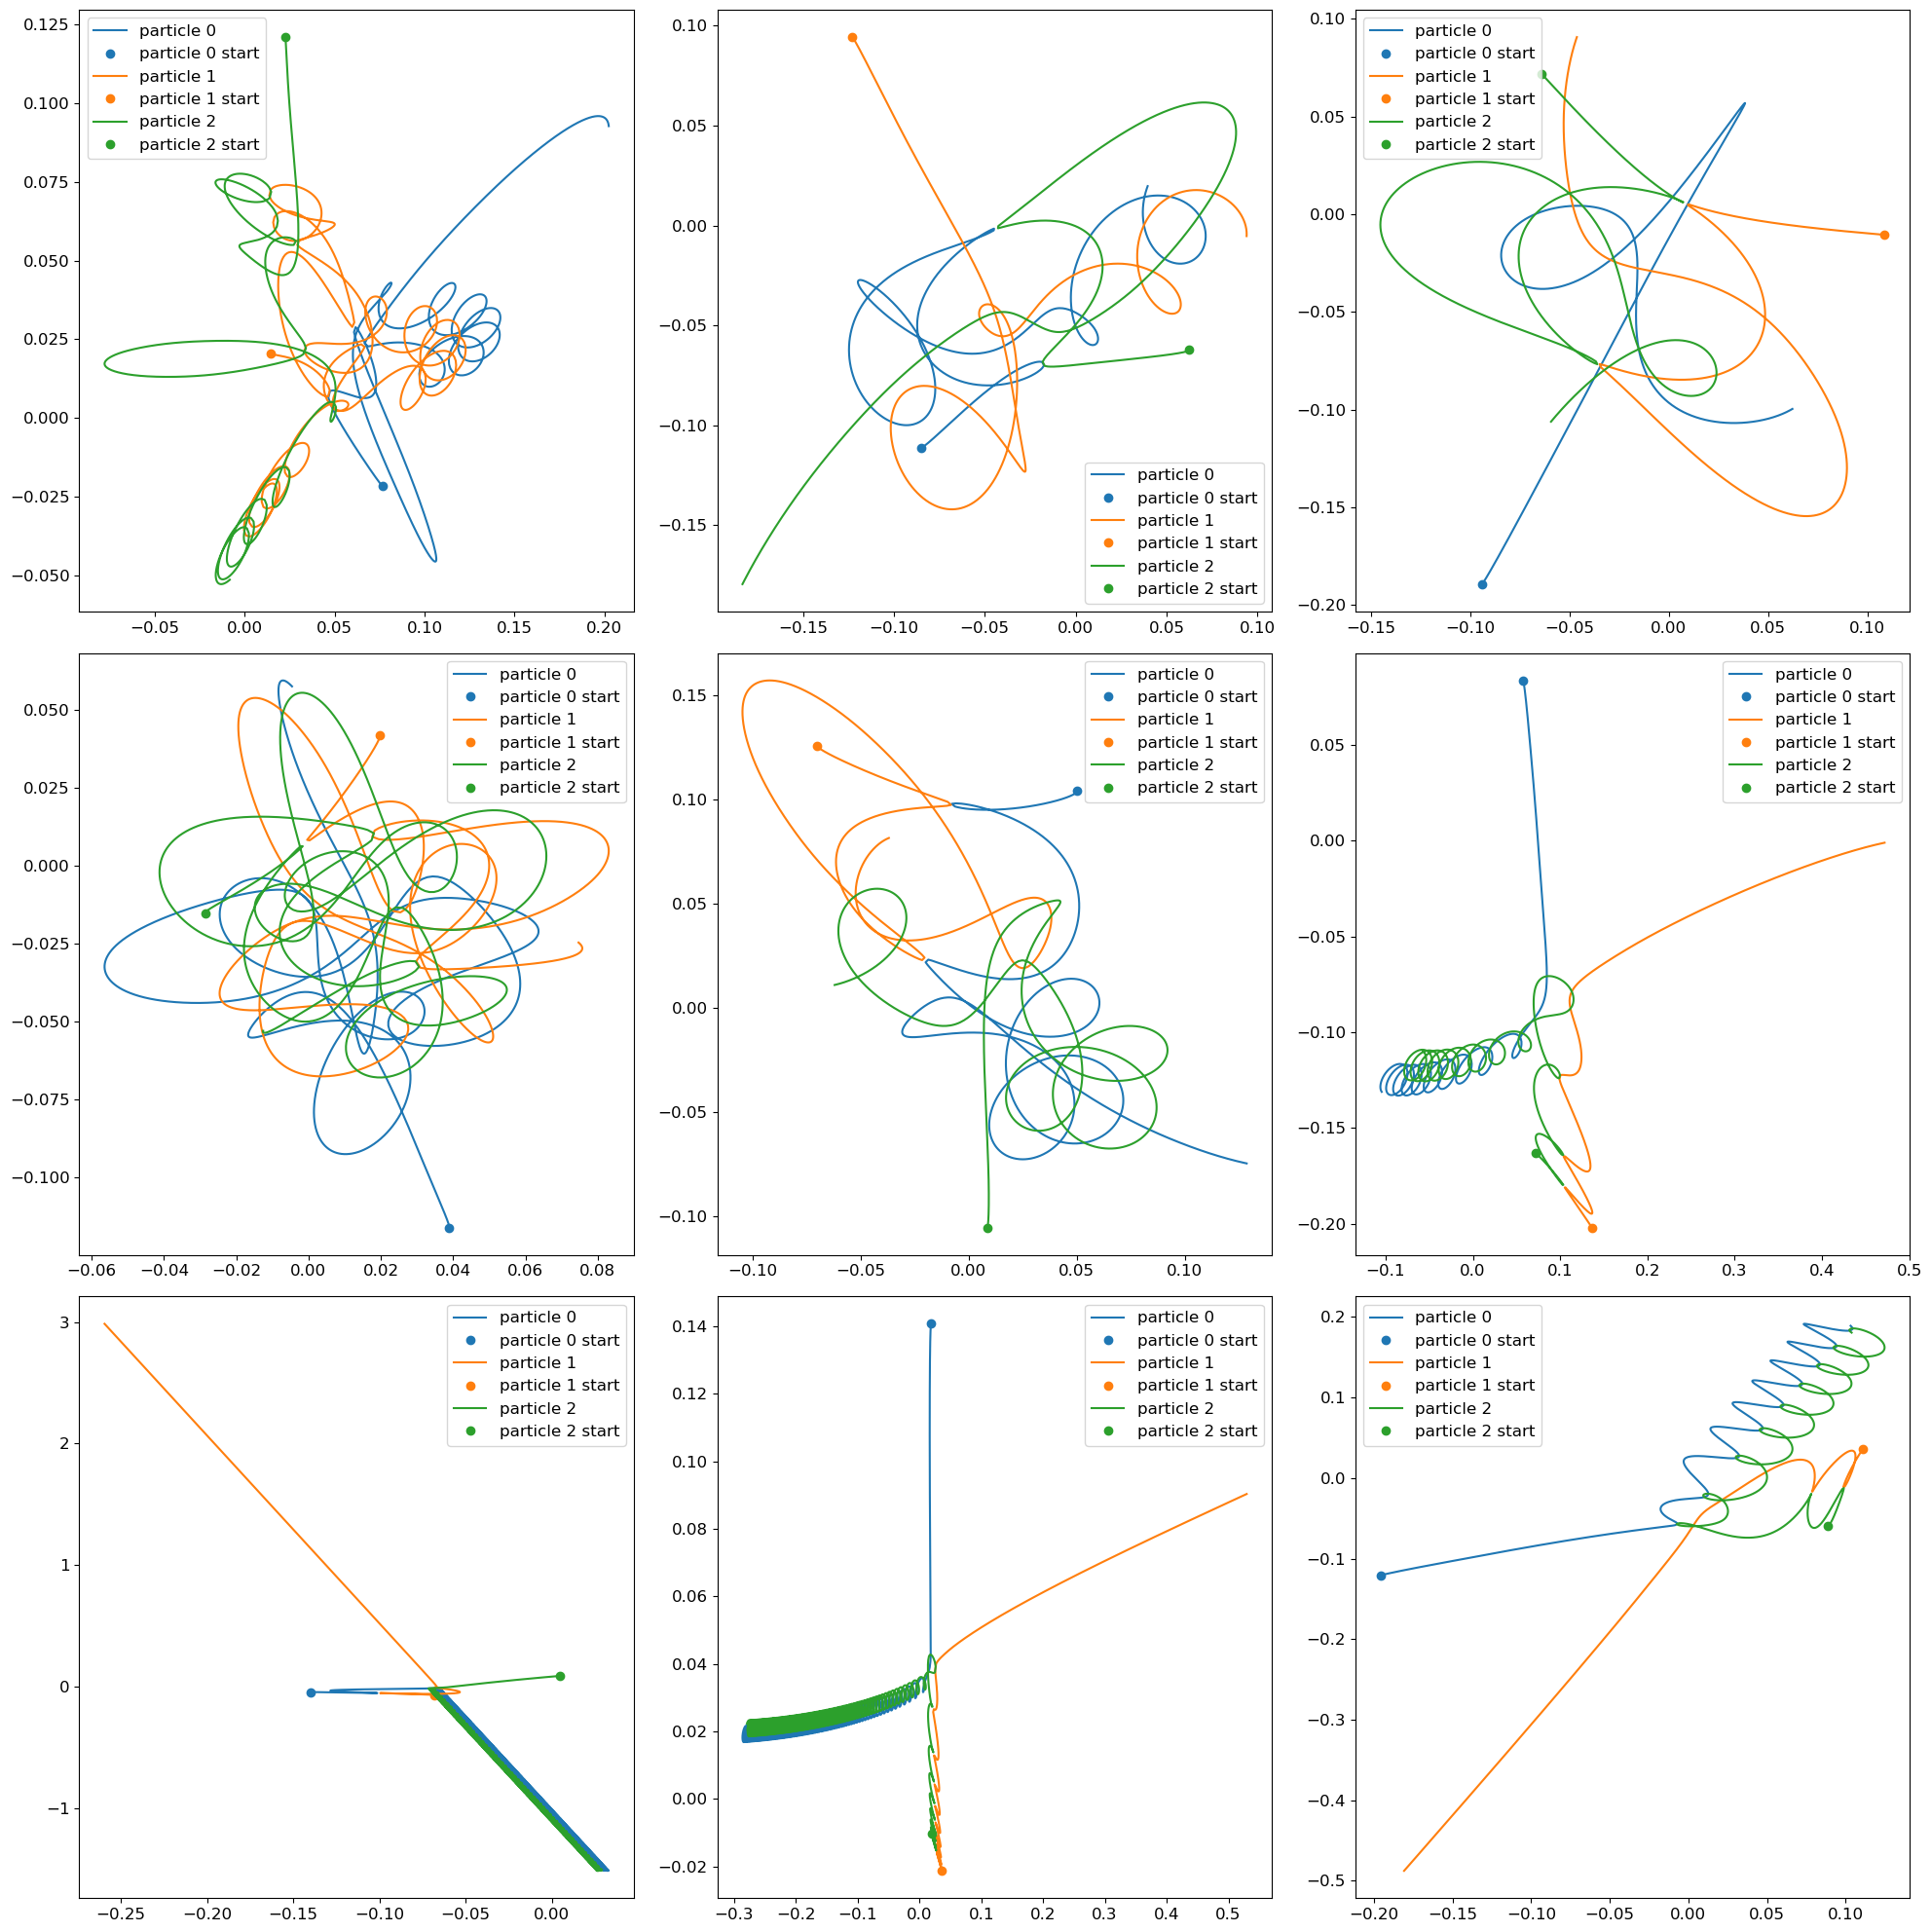

In [162]:
# old code
loop_start = 0
fig, axs = plt.subplots(3,3, figsize=(20,20))
colors = ['C0','C1','C2']
axs.resize((9,))
for i in range(9):
    for j in range( loop_start, x.shape[1], 4 ):
        label = f"particle {j//4}"
        # plot particle trajectories
        axs[i].plot(x[i*(n_timesteps+2):(i+1)*(n_timesteps+2),j], x[i*(n_timesteps+2):(i+1)*(n_timesteps+2),j+2], colors[j//4], label=label) # n_timesteps is different from actual data size, need to fix
        # plot dots for ptcl init position
        axs[i].plot(init_cond_mat[i,j],init_cond_mat[i,j+2], colors[j//4] + 'o', label=label + " start")
    axs[i].legend()
    # # plot particle trajectories
    # axs[i].plot(x[i*n_timesteps+5:(i+1)*n_timesteps,i], x[i*n_timesteps+5:(i+1)*n_timesteps,i+2],label=label)
    # axs.reshape((3,3)) # not sure if needed
fig.tight_layout()

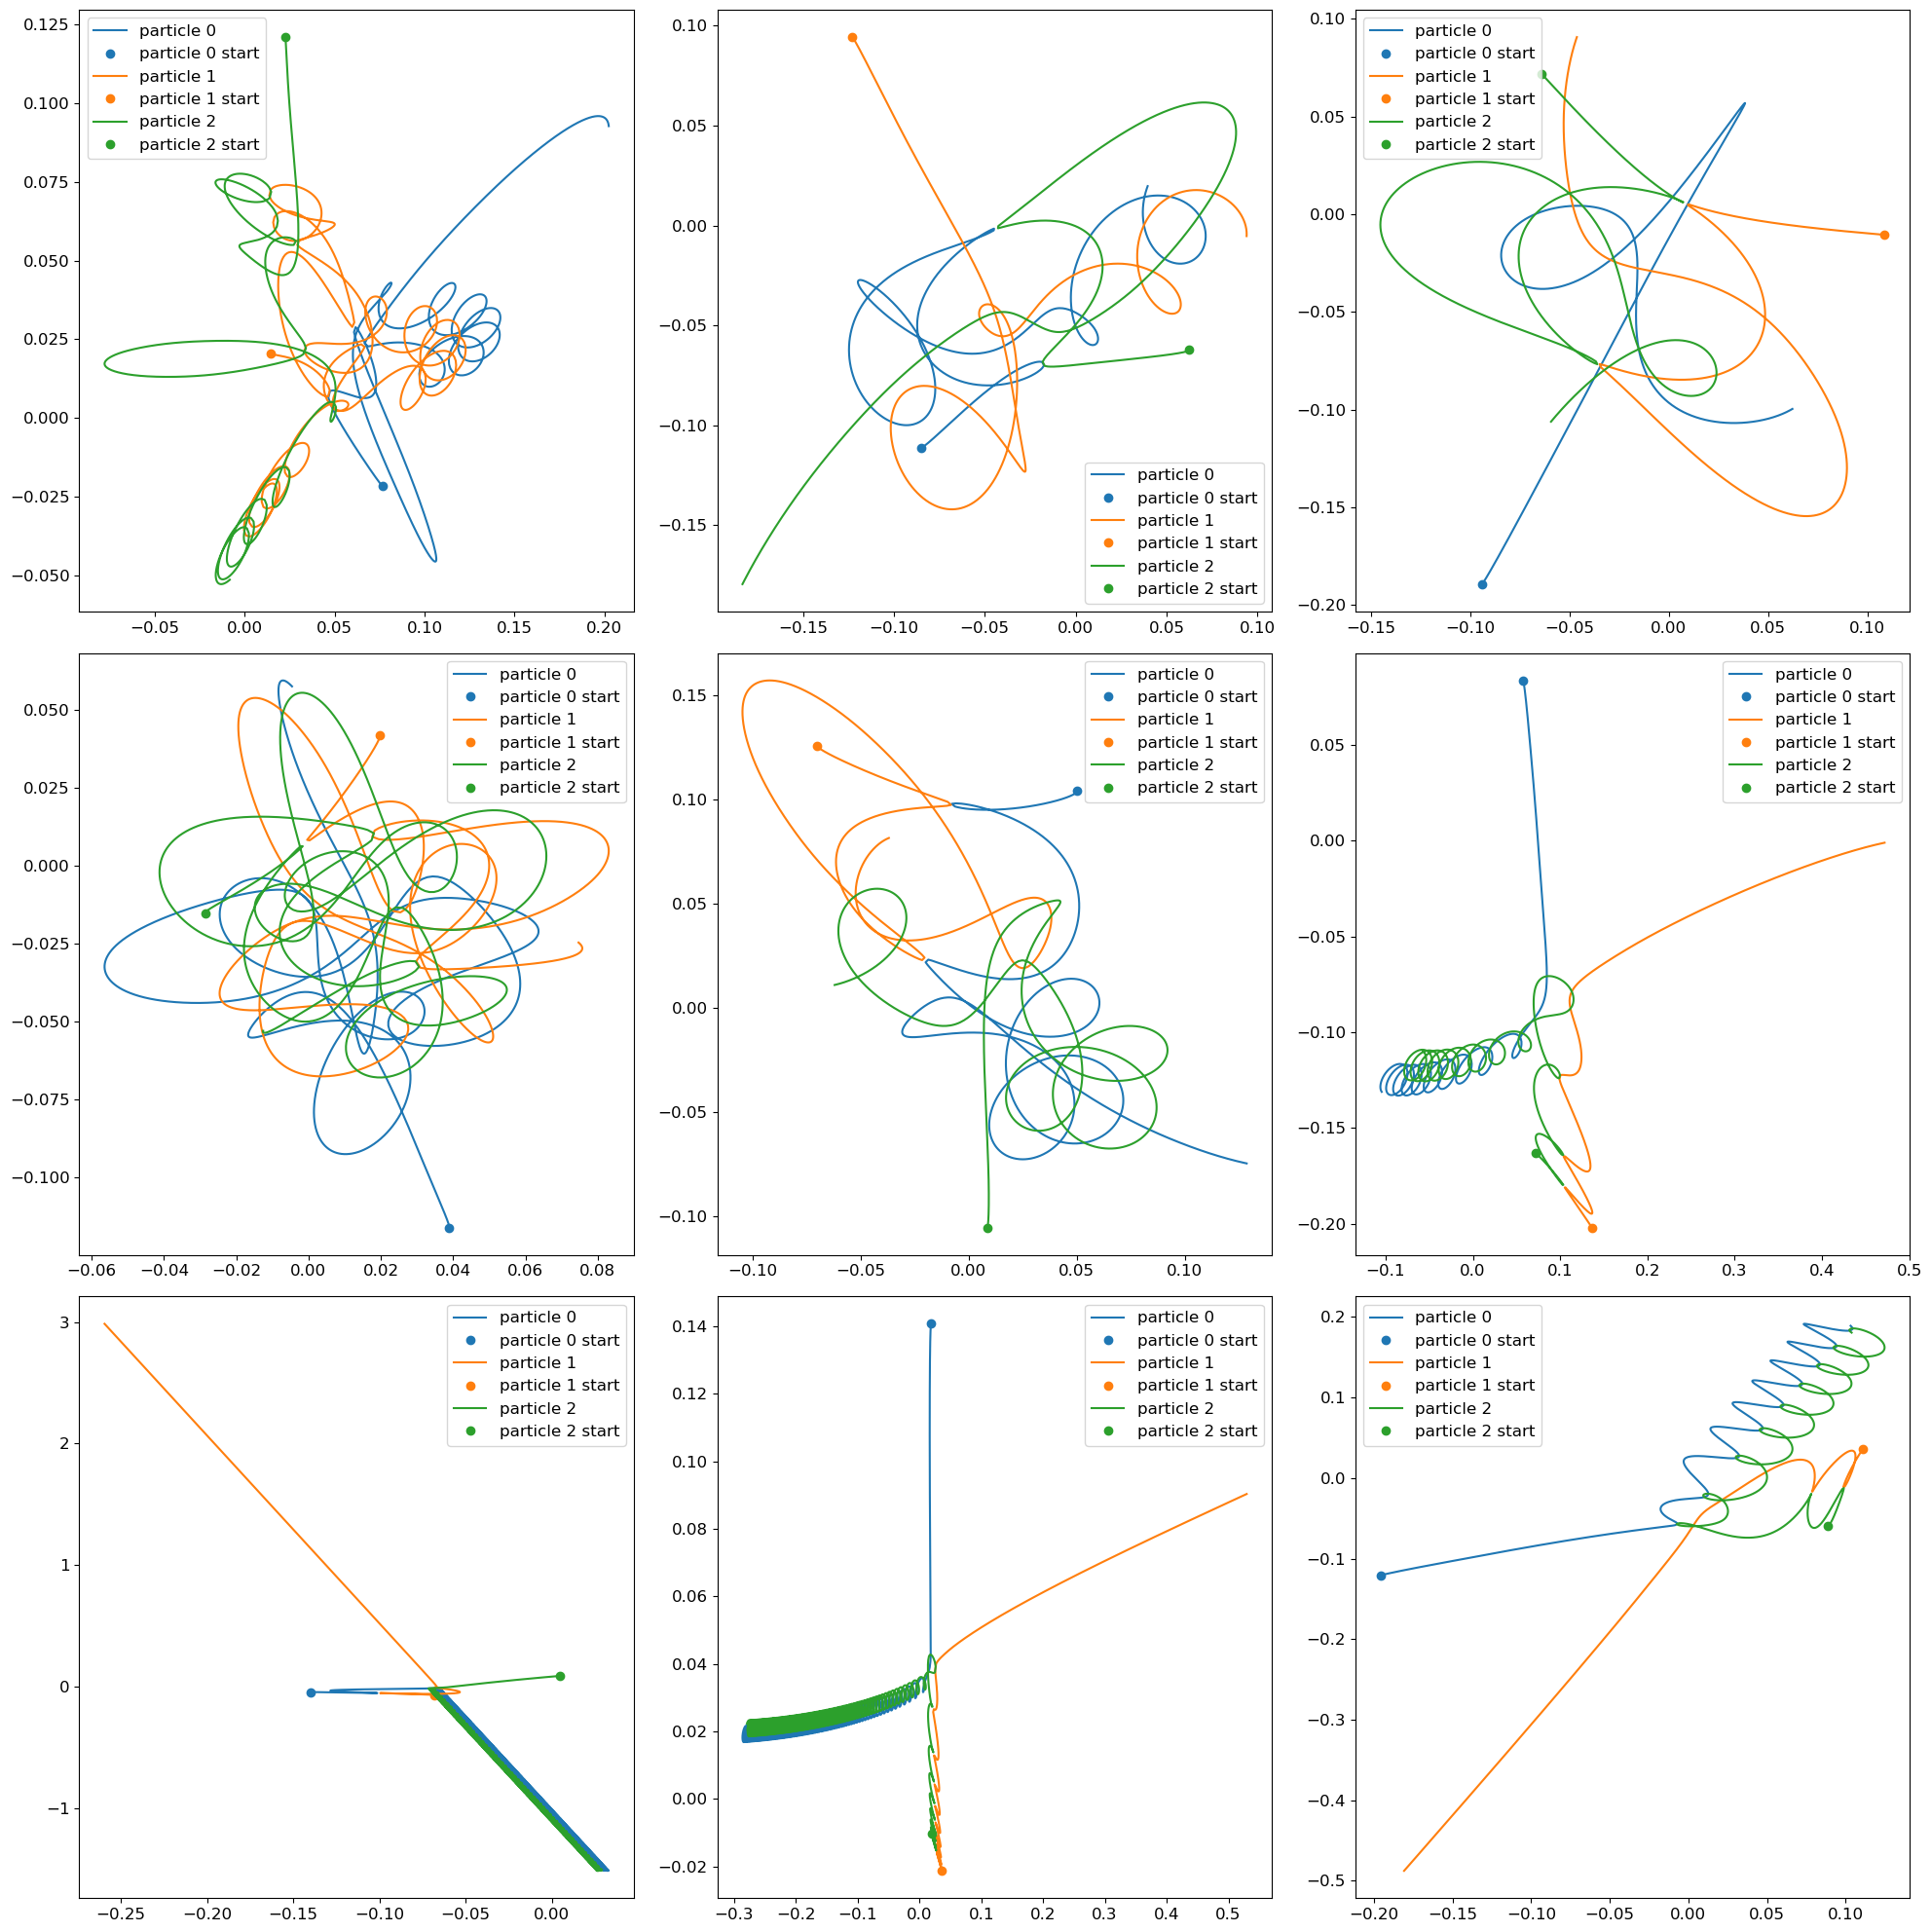

In [ ]:
def plot_multiple(x, which:str='position'):
    # desc: plots first 9 trajectories of x
    # identify which to plot using string var 'which'
    if which == 'position':
        loop_start = 0
    elif which == 'velocity':
        loop_start = 1
    else:
        raise ValueError("kwarg which which must be either 'position' or 'velocity'")
    # plot first 9 trajectories of x
    fig, axs = plt.subplots(3,3, figsize=(20,20))
    colors = ['C0','C1','C2']
    axs.resize((9,))
    for i in range(9):
        for j in range( loop_start, x[0].shape[1], 4 ):
            label = f"particle {j//4}"
            # plot particle trajectories
            axs[i].plot(x[i][:,j], x[i][:,j+2], colors[j//4], label=label)
            # plot dots for ptcl init position
            axs[i].plot(init_conds[i][j],init_conds[i][j+2], colors[j//4] + 'o', label=label + " start")
        axs[i].legend()
    fig.tight_layout()

plot_multiple(x_train)

In [209]:
# transform data
x_train_subtracted = []
for i in range(len(x_train)):
    x_train_subtracted_new, x_train_subtracted_labels = subtract_data(x_train[i])
    x_train_subtracted.append(x_train_subtracted_new)

In [ ]:
plot_multiple(x_train_subtracted)

In [210]:
len(x_train_subtracted)

20

In [211]:
x_train_subtracted[0].shape

(3001, 12)

In [213]:
opt = ps.STLSQ(threshold=0.4)
model = ps.SINDy(optimizer=opt, feature_names=x_train_labels, feature_library=generalized_library)
model.fit(x_train_subtracted, t=1e-4, multiple_trajectories=True)
model.print()

(x0-x1)' = 0.895 vx0-vx1
(vx0-vx1)' = -189850338456270.719 vx0-vx1 + -348691193316863.000 vy0-vy1 + -189850338456288.094 vx1-vx2 + -348691193316647.875 vy1-vy2 + -189850338456230.438 vx2-vx0 + -348691193316939.375 vy2-vy0 + -38.040 x0-x1 exp( sqrt( x0-x1^2 + y0-y1^2 ) ) / ( x0-x1^2 + y0-y1^2 ) + -4.475 y0-y1 exp( sqrt( x0-x1^2 + y0-y1^2 ) ) / ( x0-x1^2 + y0-y1^2 ) + -1.667 x1-x2 exp( sqrt( x1-x2^2 + y1-y2^2 ) ) / ( x1-x2^2 + y1-y2^2 ) + 18.610 y1-y2 exp( sqrt( x1-x2^2 + y1-y2^2 ) ) / ( x1-x2^2 + y1-y2^2 ) + 34.623 x2-x0 exp( sqrt( x2-x0^2 + y2-y0^2 ) ) / ( x2-x0^2 + y2-y0^2 ) + -4.069 y2-y0 exp( sqrt( x2-x0^2 + y2-y0^2 ) ) / ( x2-x0^2 + y2-y0^2 )
(y0-y1)' = 0.944 vy0-vy1
(vy0-vy1)' = -7410959196959.761 vx0-vx1 + -335057171374930.938 vy0-vy1 + -7410959197078.875 vx1-vx2 + -335057171374887.875 vy1-vy2 + -7410959196958.072 vx2-vx0 + -335057171374959.062 vy2-vy0 + -1.107 x0-x1 exp( sqrt( x0-x1^2 + y0-y1^2 ) ) / ( x0-x1^2 + y0-y1^2 ) + -88.280 y0-y1 exp( sqrt( x0-x1^2 + y0-y1^2 ) ) / ( x0-x

We are able to fit the velocity equations pretty readily with a somewhat small threshold. The 